In [1]:
%load_ext autoreload
%autoreload 2

# Function Definitions and Setup

In [2]:
import os
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

from itertools import combinations_with_replacement, combinations

In [3]:
from itertools import product

combins = [(1, 5), (2, 2), (5, 1)]
distinct = [5, 20]

df_dict = {}
for c, d in product(combins, distinct):
    df_dict[(c, d)] = pd.read_csv(os.path.join("results", f"final_{c[0] * 100}_{c[1] * 100}_{d}.csv"))

In [4]:
df_global = pd.concat([df for df in df_dict.values()])
df_global["n_claims_10k"] = df_global["n_claims"].round(-4)

df_global["Maj-Tru"] = df_global['Majority_score_perc'] - df_global['TruthFinder_score_perc']
df_global["Maj-Two"] = df_global['Majority_score_perc'] - df_global['TwoEstimates_score_perc']
df_global["Maj-Thr"] = df_global['Majority_score_perc'] - df_global['ThreeEstimates_score_perc']
df_global["Tru-Two"] = df_global['TruthFinder_score_perc'] - df_global['TwoEstimates_score_perc']
df_global["Tru-Thr"] = df_global['TruthFinder_score_perc'] - df_global['ThreeEstimates_score_perc']
df_global["Two-Thr"] = df_global['TwoEstimates_score_perc'] - df_global['ThreeEstimates_score_perc']

maj_list = ['Majority_score_perc_1', 'Majority_score_perc_2', 'Majority_score_perc_3']
tru_list = ['TruthFinder_score_perc_1', 'TruthFinder_score_perc_2', 'TruthFinder_score_perc_3']
two_list = ['TwoEstimates_score_perc_1', 'TwoEstimates_score_perc_2', 'TwoEstimates_score_perc_3']
thr_list = ['ThreeEstimates_score_perc_1', 'ThreeEstimates_score_perc_2', 'ThreeEstimates_score_perc_3']

df_global["Majority_score_perc_max"] = df_global[maj_list].max(axis=1)
df_global["Majority_score_perc_min"] = df_global[maj_list].min(axis=1)
df_global["TruthFinder_score_perc_max"] = df_global[tru_list].max(axis=1)
df_global["TruthFinder_score_perc_min"] = df_global[tru_list].min(axis=1)
df_global["TwoEstimates_score_perc_max"] = df_global[two_list].max(axis=1)
df_global["TwoEstimates_score_perc_min"] = df_global[two_list].min(axis=1)
df_global["ThreeEstimates_score_perc_max"] = df_global[thr_list].max(axis=1)
df_global["ThreeEstimates_score_perc_min"] = df_global[thr_list].min(axis=1)

df_global["Majority_score_perc_diff"] = df_global["Majority_score_perc_max"] - df_global["Majority_score_perc_min"]
df_global["TruthFinder_score_perc_diff"] = df_global["TruthFinder_score_perc_max"] - df_global["TruthFinder_score_perc_min"]
df_global["TwoEstimates_score_perc_diff"] = df_global["TwoEstimates_score_perc_max"] - df_global["TwoEstimates_score_perc_min"]
df_global["ThreeEstimates_score_perc_diff"] = df_global["ThreeEstimates_score_perc_max"] - df_global["ThreeEstimates_score_perc_min"]

df_global["win_Majority"] = (df_global["Majority_score"] >= df_global["TruthFinder_score"]) & \
                            (df_global["Majority_score"] >= df_global["TwoEstimates_score"]) & \
                            (df_global["Majority_score"] >= df_global["ThreeEstimates_score"])

df_global["win_TruthFinder"] = (df_global["TruthFinder_score"] >= df_global["Majority_score"]) & \
                               (df_global["TruthFinder_score"] >= df_global["TwoEstimates_score"]) & \
                               (df_global["TruthFinder_score"] >= df_global["ThreeEstimates_score"])

df_global["win_TwoEstimates"] = (df_global["TwoEstimates_score"] >= df_global["Majority_score"]) & \
                                (df_global["TwoEstimates_score"] >= df_global["TruthFinder_score"]) & \
                                (df_global["TwoEstimates_score"] >= df_global["ThreeEstimates_score"])

df_global["win_ThreeEstimates"] = (df_global["ThreeEstimates_score"] >= df_global["Majority_score"]) & \
                                  (df_global["ThreeEstimates_score"] >= df_global["TruthFinder_score"]) & \
                                  (df_global["ThreeEstimates_score"] >= df_global["TwoEstimates_score"])

df_global["_agg_total"] = 1
df_global.to_csv(os.path.join("results", f"final_combined.csv"), index=False)

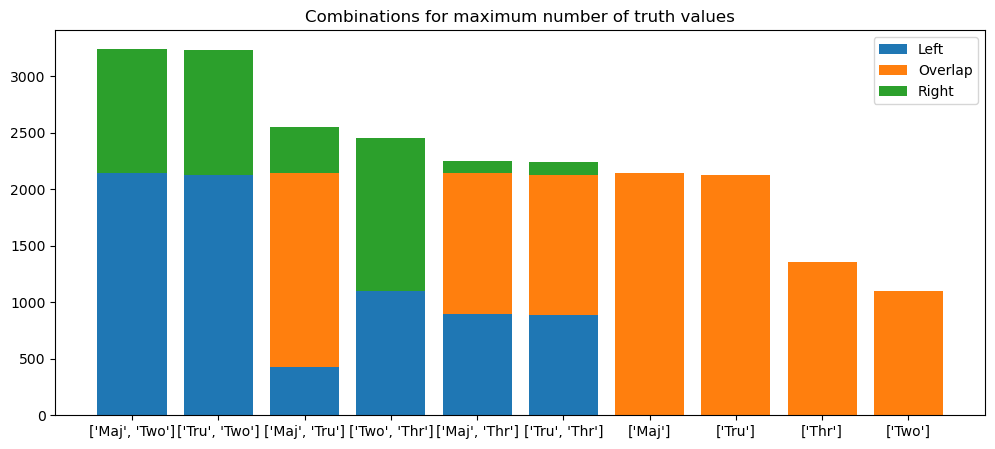

In [5]:
def plot_counts():
    counts_left, counts_both, counts_right, counts_total = {}, {}, {}, {}
    winners = ["win_Majority", "win_TruthFinder", "win_TwoEstimates", "win_ThreeEstimates"]
    for comb in combinations_with_replacement(winners, 2):
        count_left = len(df_global[df_global[comb[0]] & ~df_global[comb[1]]])
        count_both = len(df_global[df_global[comb[0]] & df_global[comb[1]]])
        count_right = len(df_global[~df_global[comb[0]] & df_global[comb[1]]])
        count = count_left + count_both + count_right
        
        if comb[0] == comb[1]: 
            comb = tuple([comb[0]])
        
        if comb not in counts_left:
            counts_left[comb] = count_left
        if comb not in counts_both:
            counts_both[comb] = count_both
        if comb not in counts_right:
            counts_right[comb] = count_right
        if comb not in counts_total:
            counts_total[comb] = count

    fig = plt.figure(figsize=(12, 5))
    ax = fig.add_subplot(1, 1, 1)
      
    counts_indices = np.flip(np.argsort(list(counts_total.values())))
    
    bottom = np.zeros(len(counts_left))
    for counts_dict, label in zip([counts_left, counts_both, counts_right], ['Left', 'Overlap', 'Right']):
        a, b = zip(*counts_dict.items())
        ax.bar(range(len(a)), np.take_along_axis(np.array(b), counts_indices, axis=0), bottom=bottom, label=label)
        #ax.bar(range(len(a)), b, bottom=bottom, label=label)
        bottom += np.take_along_axis(np.array(b), counts_indices, axis=0)
        a = [[x.split("_")[1][:3] for x in y] for y in a]
        
    #ax.set_xticks(counts_indices, [[x.split("_")[1][:3] for x in y] for y in a], rotation=0)
    ax.set_xticks(range(len(a)), np.take_along_axis(np.array(a, dtype=object), counts_indices, axis=0), rotation=0)
    ax.legend()
    ax.set_title("Combinations for maximum number of truth values")
    plt.show()

plot_counts()

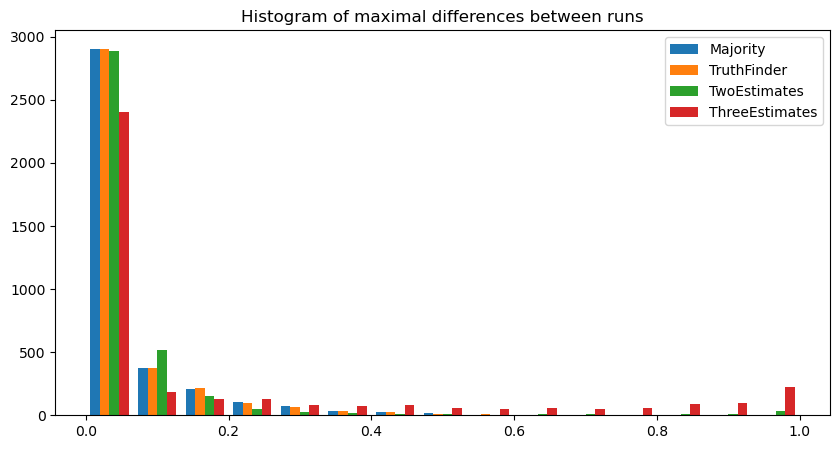

20
19
88
642


In [6]:
plt.figure(figsize=(10, 5))
plt.title("Histogram of maximal differences between runs")
plt.hist([df_global['Majority_score_perc_diff'], df_global['TruthFinder_score_perc_diff'],
          df_global['TwoEstimates_score_perc_diff'], df_global['ThreeEstimates_score_perc_diff']], 
         label=['Majority', 'TruthFinder', 'TwoEstimates', 'ThreeEstimates'], bins=15)
plt.legend()
plt.show()

print(df_global['Majority_score_perc_diff'][df_global['Majority_score_perc_diff'] > 0.5].count())
print(df_global['TruthFinder_score_perc_diff'][df_global['TruthFinder_score_perc_diff'] > 0.5].count())
print(df_global['TwoEstimates_score_perc_diff'][df_global['TwoEstimates_score_perc_diff'] > 0.5].count())
print(df_global['ThreeEstimates_score_perc_diff'][df_global['ThreeEstimates_score_perc_diff'] > 0.5].count())


# Globals and Pairwise

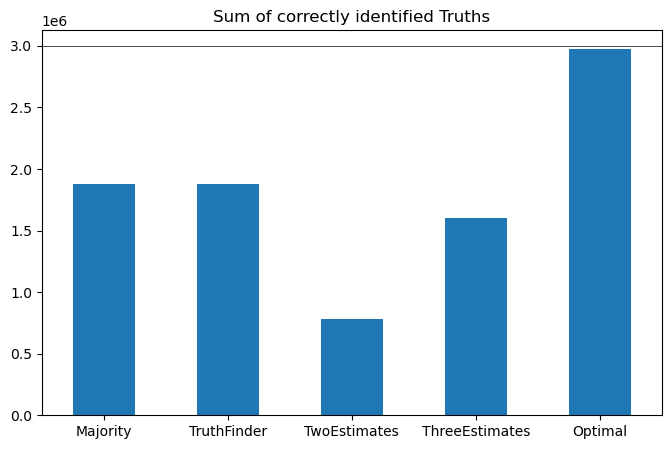

Majority_score          1880549.0
TruthFinder_score       1880712.0
TwoEstimates_score       779147.0
ThreeEstimates_score    1604697.0
optimal_score           2978114.0
dtype: float64
3000000.0
Majority_score          0.626850
TruthFinder_score       0.626904
TwoEstimates_score      0.259716
ThreeEstimates_score    0.534899
optimal_score           0.992705
dtype: float64


In [7]:
total_dataitems = ((df_global.shape[0] / 3) * np.array([100, 200, 500])).sum() * 3
total_truths = df_global[['Majority_score', 'TruthFinder_score', 'TwoEstimates_score', 'ThreeEstimates_score', 'optimal_score']].sum() * 3

def plot_totals():
    fig = plt.figure(figsize=(8, 5))
    ax = fig.add_subplot(1, 1, 1)
    total_truths.plot(kind="bar", ax=ax, rot=0)
    ax.set_xticks([0, 1, 2, 3, 4], ['Majority', 'TruthFinder', 'TwoEstimates', 'ThreeEstimates', 'Optimal'])
    ax.set_title("Sum of correctly identified Truths")
    ax.axhline(total_dataitems, lw=0.5, c="black", alpha=1.0)
    plt.show()

plot_totals()
print(total_truths)
print(total_dataitems)
print(total_truths / total_dataitems)

In [8]:
def plot_pairwise(col, title="Global Results for X-Axis Value", agg_type="mean", plot_type="bar", rot=0):
    y_cols = ["Maj-Tru", "Maj-Two", "Maj-Thr", "Tru-Two", "Tru-Thr", "Two-Thr"]

    fig = plt.figure(figsize=(8, 5))
    ax = fig.add_subplot(1, 1, 1)
    
    if not isinstance(col, list):
        col = [col]        
    
    df_plot = df_global.groupby(col).agg(agg_type, numeric_only=True)[y_cols].reset_index()
        
    if set(df_plot[col[0]].unique()) == set(['F_TruncPareto', 'F_TruncExponential', 'Uniform', 'TruncExponential', 'TruncPareto']):
        df_plot[col[0]] = df_plot[col[0]].astype("category")
        df_plot[col[0]] = df_plot[col[0]].cat.set_categories(['F_TruncPareto', 'F_TruncExponential', 'Uniform', 'TruncExponential', 'TruncPareto'])
        df_plot = df_plot.sort_values(col)
        
    df_plot.plot(kind=plot_type, x=col[0], y=y_cols, ax=ax, rot=rot, legend=False, 
                 color=['darkblue', 'royalblue', 'lightblue', 'darkorange', 'gold', 'green'])
    
    ax.set_title(title)
    ax.legend(y_cols, loc='lower center', bbox_to_anchor=(0.5, -0.22), ncols=6)
    
    if col[0] == '_agg_total':
        ax.axes.get_xaxis().set_visible(False)
        ax.legend(y_cols, loc='lower center', bbox_to_anchor=(0.5, -0.1), ncols=6)

    ax.axhline(0.0, lw=0.5, c="black", alpha=1.0)

    plt.show()
    

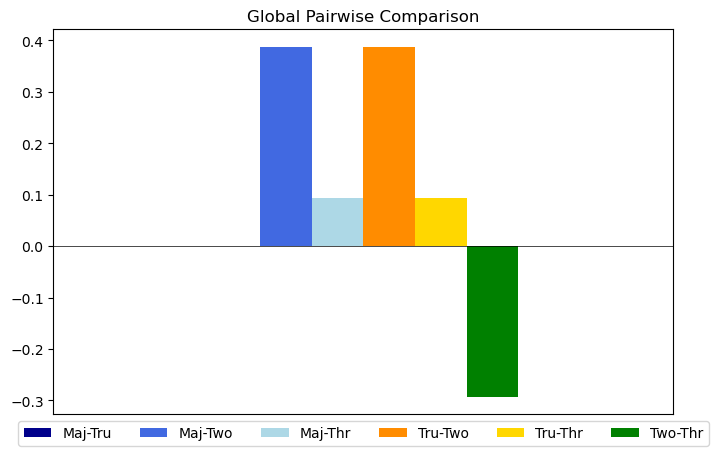

In [9]:
plot_pairwise(col='_agg_total', title="Global Pairwise Comparison")

# Global Analysis

In [10]:
def plot_global(col, percent=True, title="Global Results for X-Axis Value", agg_type="mean", plot_type="bar", rot=0, df_filter=None):
    y_cols = ["Majority_score", "TruthFinder_score", "TwoEstimates_score", "ThreeEstimates_score"]
    if percent:
        y_cols = [value + "_perc" for value in y_cols]
        y_cols.append("optimal_perc_score")
    else:
        y_cols.append("optimal_score")


    fig = plt.figure(figsize=(8, 5))
    ax = fig.add_subplot(1, 1, 1)
    
    if not isinstance(col, list):
        col = [col]        
    
    if df_filter is not None:
        df_filtered = df_global.query(df_filter)
    else:
        df_filtered = df_global
    
    df_plot = df_filtered.groupby(col).agg(agg_type, numeric_only=True)[y_cols].reset_index()
        
    if set(df_plot[col[0]].unique()) == set(['F_TruncPareto', 'F_TruncExponential', 'Uniform', 'TruncExponential', 'TruncPareto']):
        df_plot[col[0]] = df_plot[col[0]].astype("category")
        df_plot[col[0]] = df_plot[col[0]].cat.set_categories(['F_TruncPareto', 'F_TruncExponential', 'Uniform', 'TruncExponential', 'TruncPareto'])
        df_plot = df_plot.sort_values(col)
        
    df_plot.plot(kind=plot_type, x=col[0], y=y_cols, ax=ax, rot=rot, legend=False)
    
    if percent:
        ax.set_ylim([0, 1])

    ax.set_title(title)
    ax.legend(["Majority", "TruthFinder", "TwoEstimates", "ThreeEstimates", "Optimal"], loc='lower center', bbox_to_anchor=(0.5, -0.22), ncols=5)
    plt.show()
    

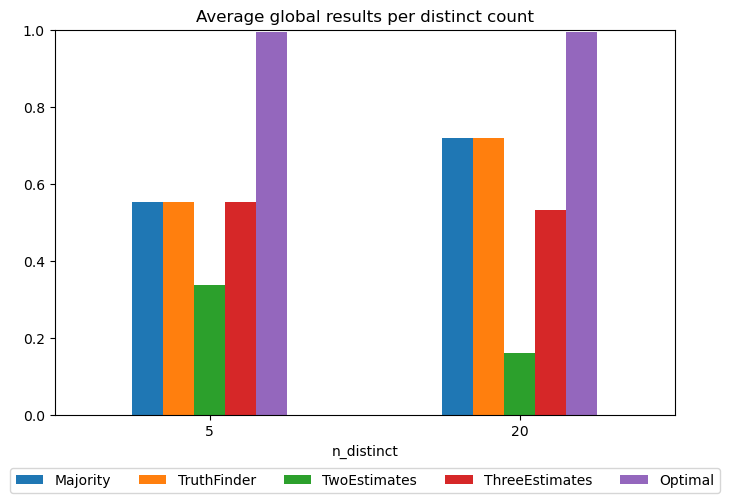

In [11]:
plot_global(col='n_distinct', title="Average global results per distinct count")

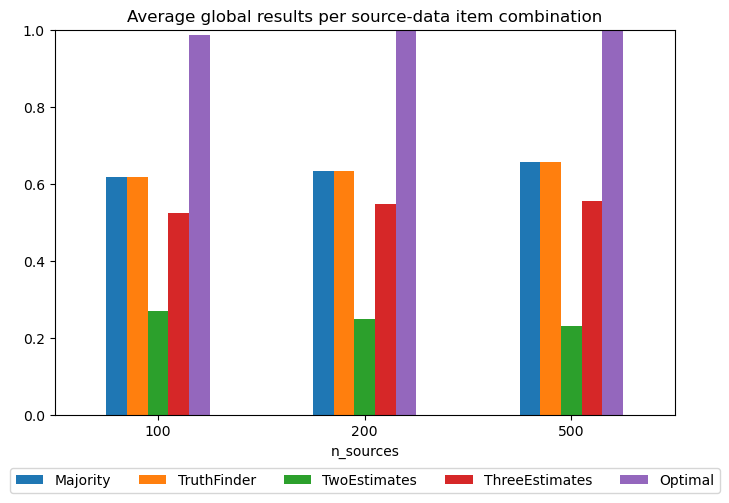

In [12]:
plot_global(col='n_sources', title="Average global results per source-data item combination")

In [13]:
import datetime

total_time = 0
total_time += df_global['Majority_time'].sum()
total_time += df_global['TruthFinder_time'].sum()
total_time += df_global['TwoEstimates_time'].sum()
total_time += df_global['ThreeEstimates_time'].sum()
total_time *= 3

m, s = divmod(int(total_time), 60)
h, m = divmod(m, 60)

print(f'{h:d}h {m:02d}m {s:02d}s')

25h 51m 24s


# Split Results

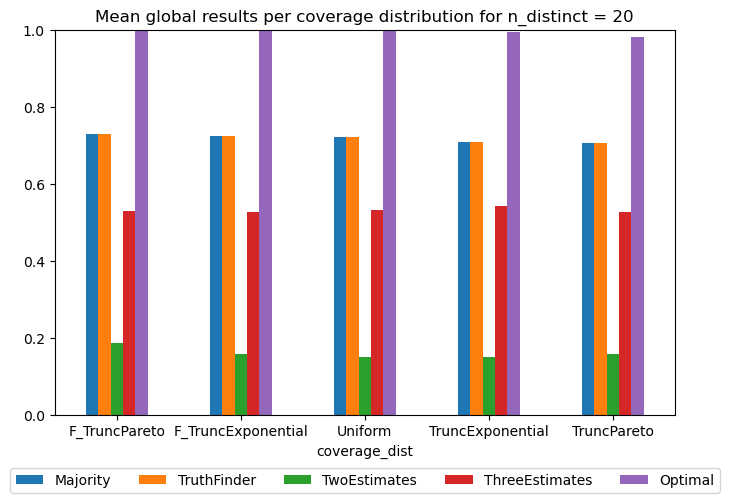

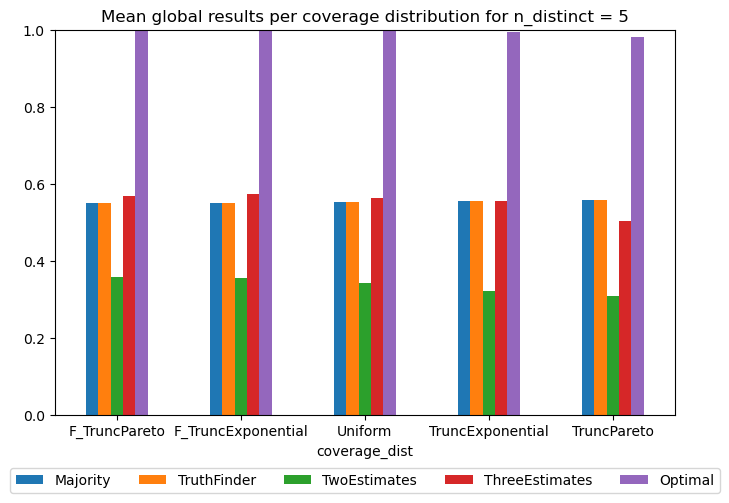

In [14]:
plot_global(col='coverage_dist', title="Mean global results per coverage distribution for n_distinct = 20", 
            df_filter="n_distinct == 20", plot_type="bar")
plot_global(col='coverage_dist', title="Mean global results per coverage distribution for n_distinct = 5", 
            df_filter="n_distinct == 5", plot_type="bar")


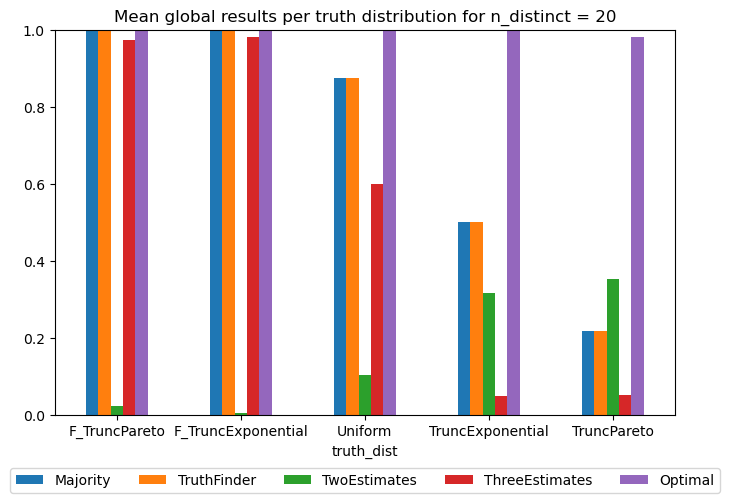

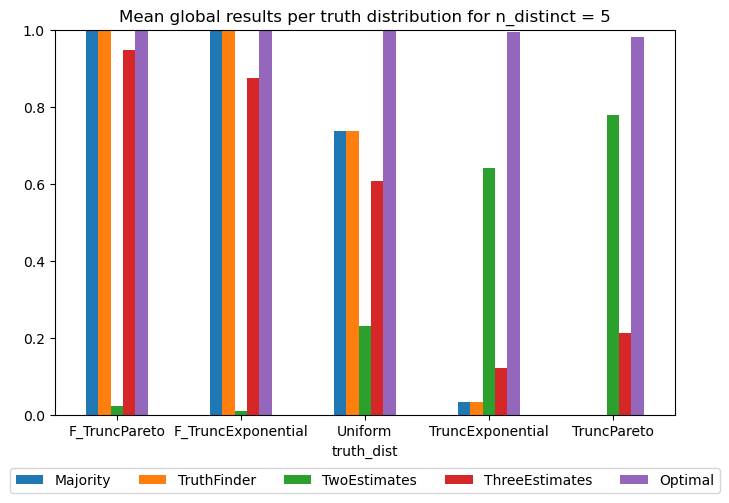

In [15]:
plot_global(col='truth_dist', title="Mean global results per truth distribution for n_distinct = 20", 
            df_filter="n_distinct == 20", plot_type="bar")
plot_global(col='truth_dist', title="Mean global results per truth distribution for n_distinct = 5", 
            df_filter="n_distinct == 5", plot_type="bar")

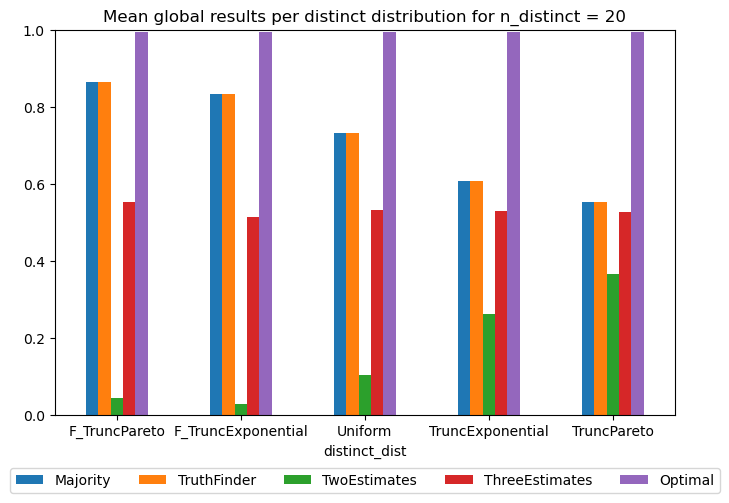

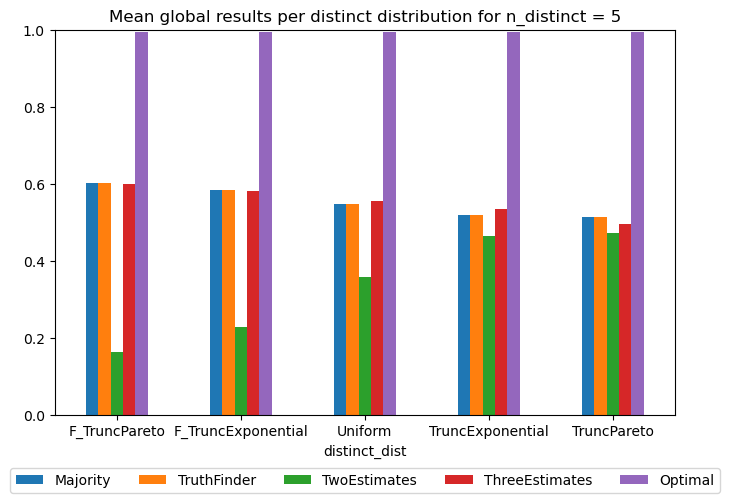

In [16]:
plot_global(col='distinct_dist', title="Mean global results per distinct distribution for n_distinct = 20", df_filter="n_distinct == 20")
plot_global(col='distinct_dist', title="Mean global results per distinct distribution for n_distinct = 5", df_filter="n_distinct == 5")

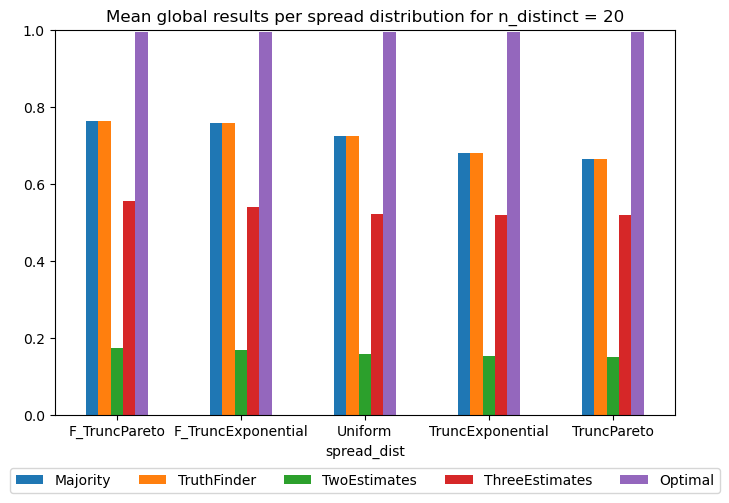

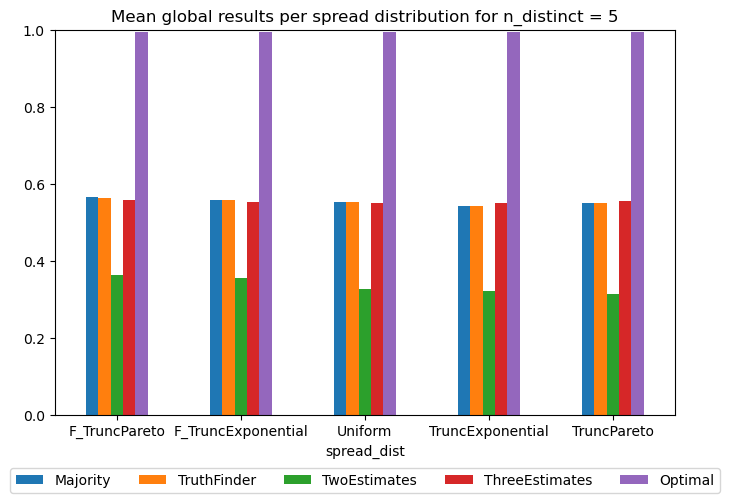

In [17]:
plot_global(col='spread_dist', title="Mean global results per spread distribution for n_distinct = 20", df_filter="n_distinct == 20")
plot_global(col='spread_dist', title="Mean global results per spread distribution for n_distinct = 5", df_filter="n_distinct == 5")

# Distribution Globals

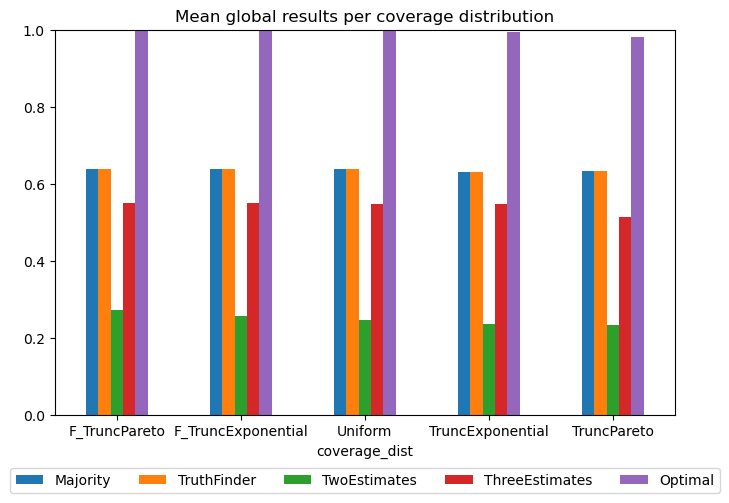

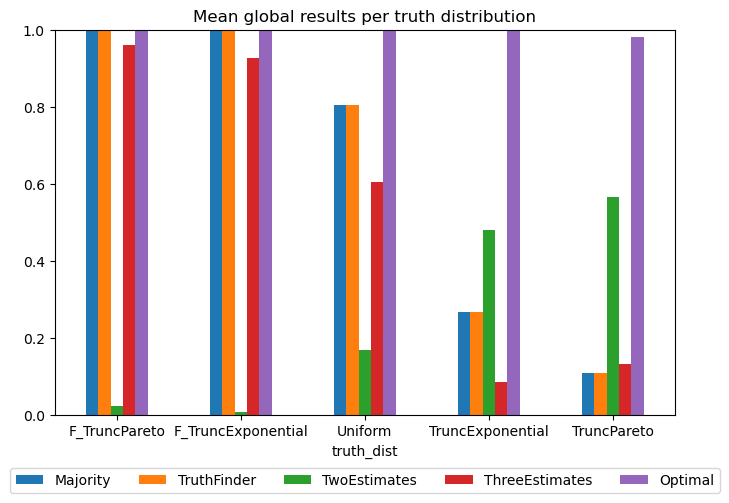

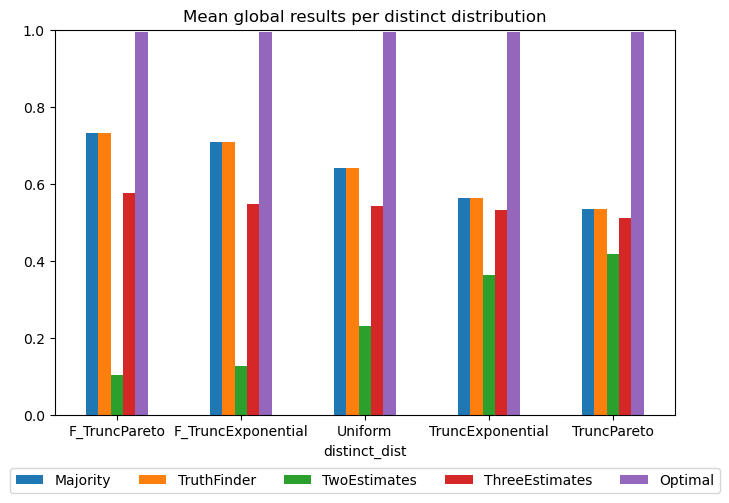

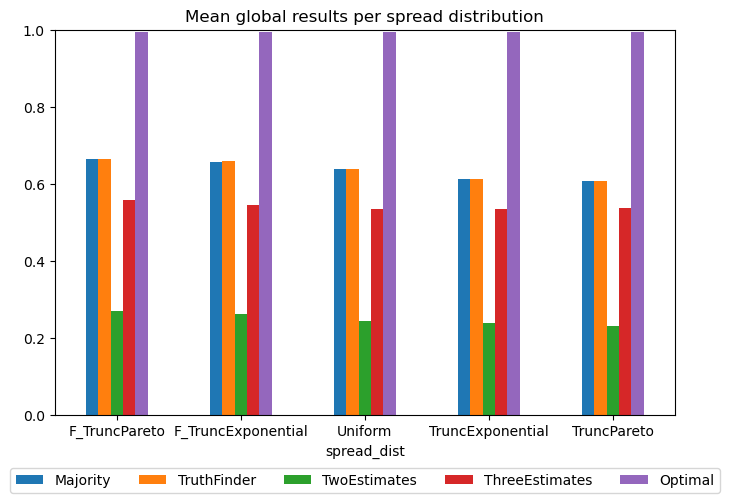

In [18]:
plot_global(col='coverage_dist', title="Mean global results per coverage distribution")
plot_global(col='truth_dist', title="Mean global results per truth distribution")
plot_global(col='distinct_dist', title="Mean global results per distinct distribution")
plot_global(col='spread_dist', title="Mean global results per spread distribution")

# Distribution Ablations

In [19]:
def plot_distribution(base='F_TruncPareto', distribution='coverage_dist', percent=True):
    y_cols = ["Majority_score", "TruthFinder_score", "TwoEstimates_score", "ThreeEstimates_score"]
    if percent:
        y_cols = [value + "_perc" for value in y_cols]
        y_cols.append("optimal_perc_score")
    else:
        y_cols.append("optimal_score")
    
    equals = list(set(['coverage_dist', 'truth_dist', 'distinct_dist', 'spread_dist']).difference(set([distribution])))
    
    fig = plt.figure(figsize=(24, 4), dpi=300)

    for i, (d, c) in enumerate(product(distinct, combins)):
        df = df_dict[(c, d)]
        plotter = df[(df[equals[0]] == base) & (df[equals[1]] == base) & (df[equals[2]] == base)]
        
        ax = fig.add_subplot(2, 3, i+1)
        plotter.plot(kind="bar", x=distribution, y=y_cols, ax=ax, sharex=True, rot=7, legend=False)
        ax.set_title(f"Sources = {c[0] * 100} | DataItems = {c[1] * 100} | Distinct = {d}")
        ax.set_ylim([0, 1])
        
        if i == 1:
            ax.legend(["Majority", "TruthFinder", "TwoEstimates", "ThreeEstimates", "Optimal"], loc='lower center', bbox_to_anchor=(0.5, 1.15), ncols=5)
    plt.show()


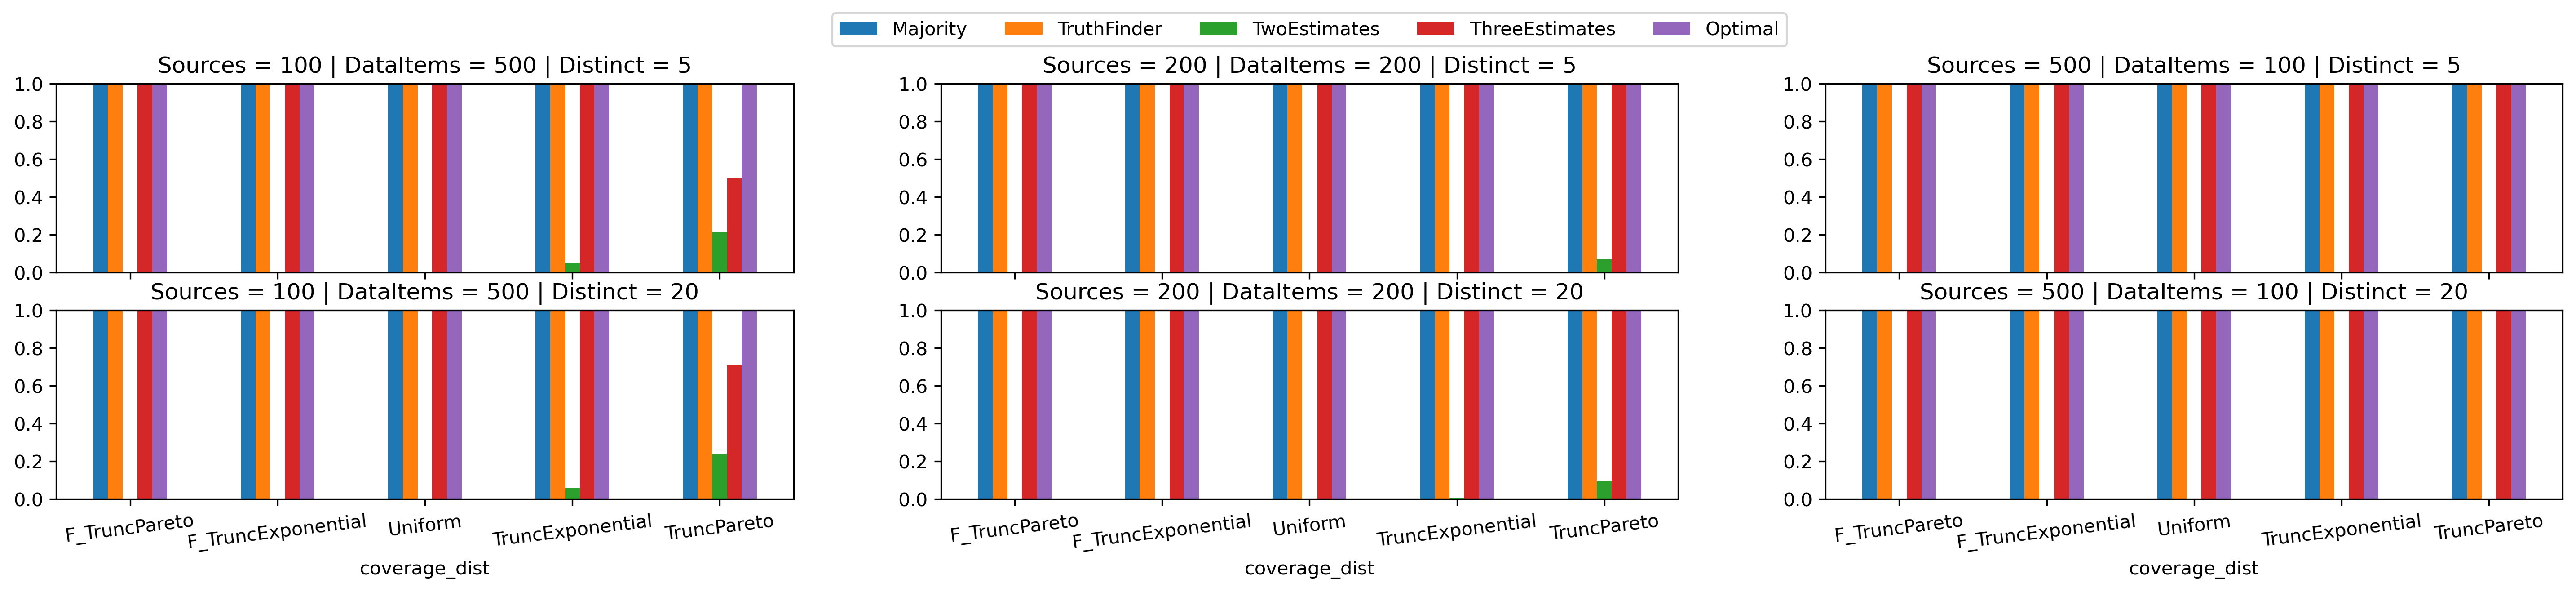

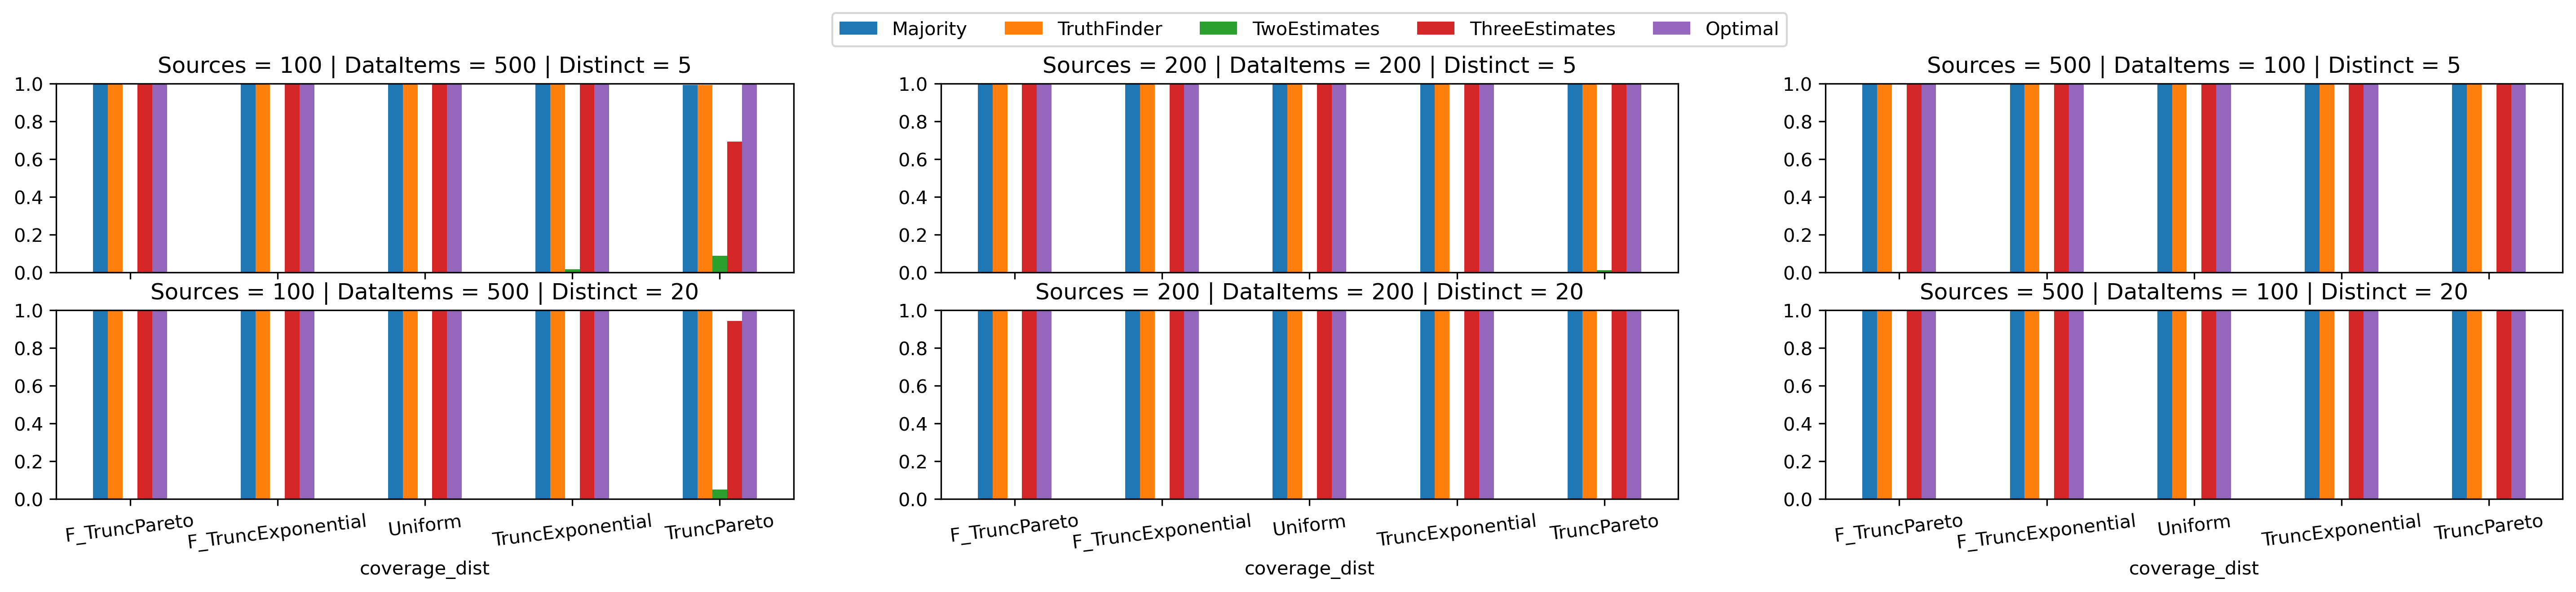

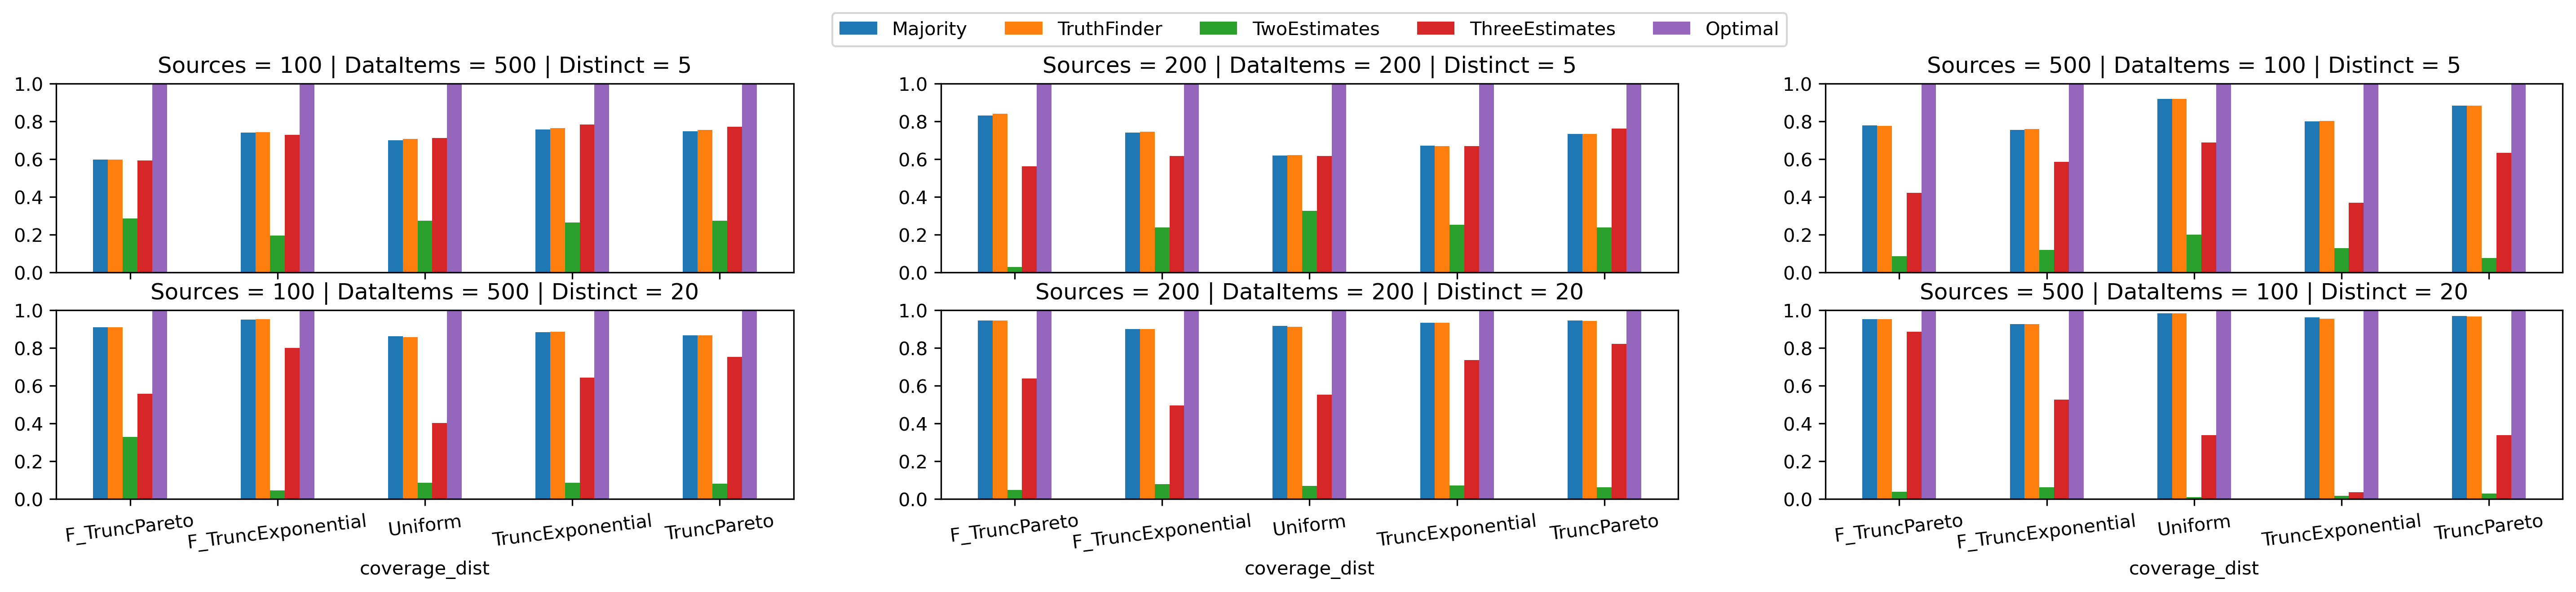

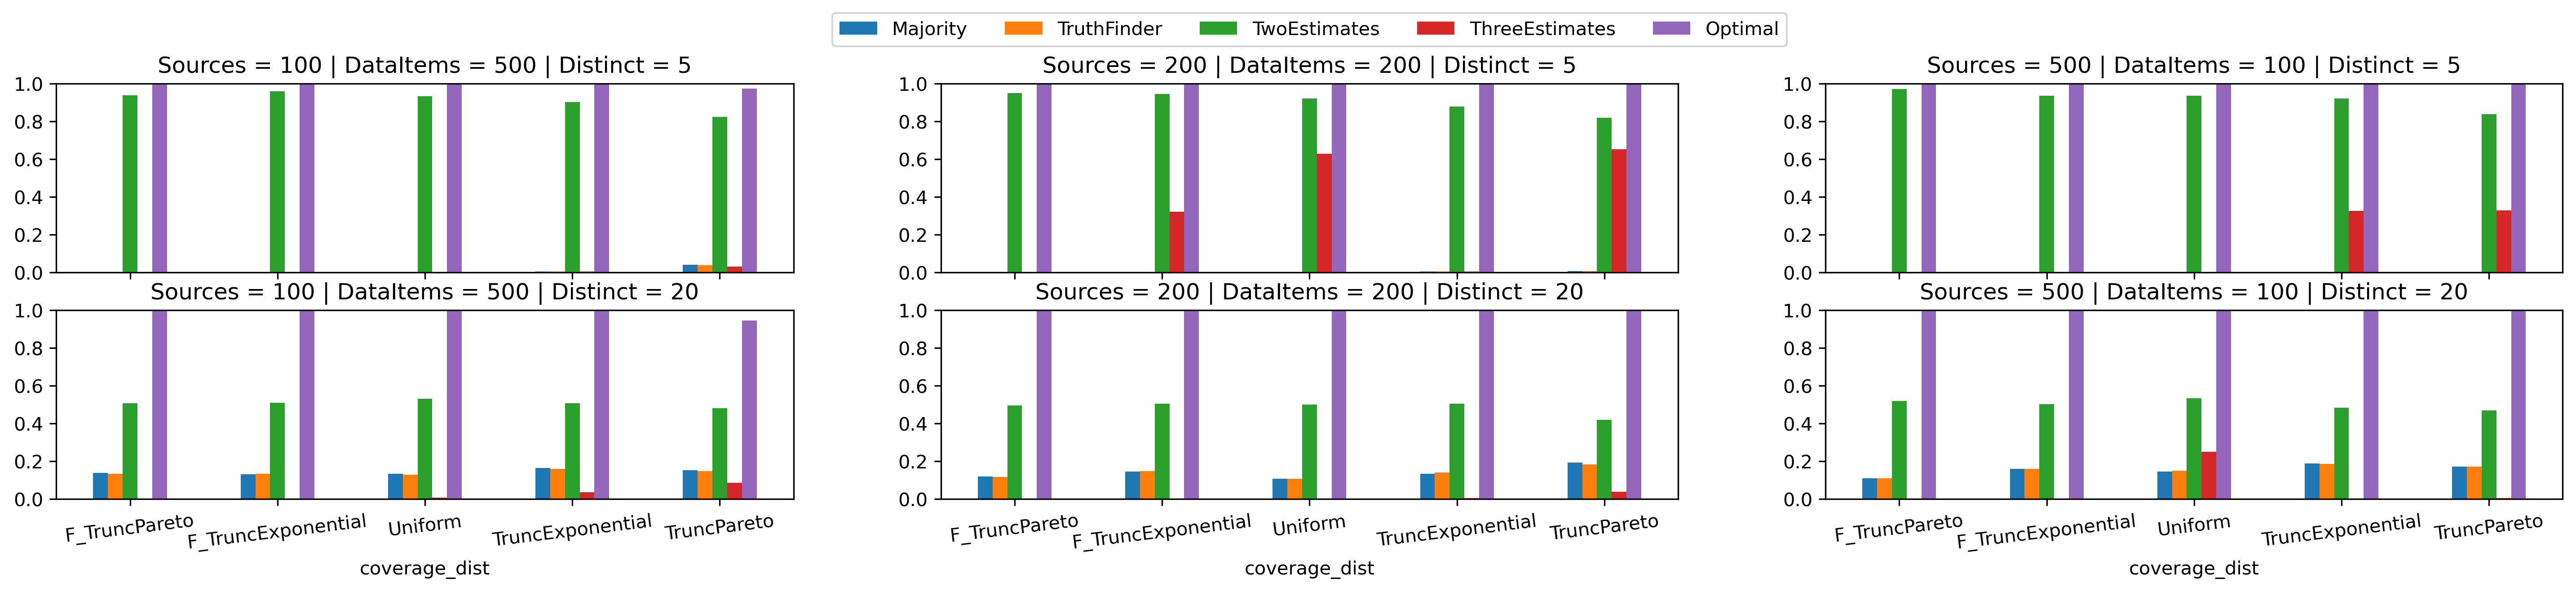

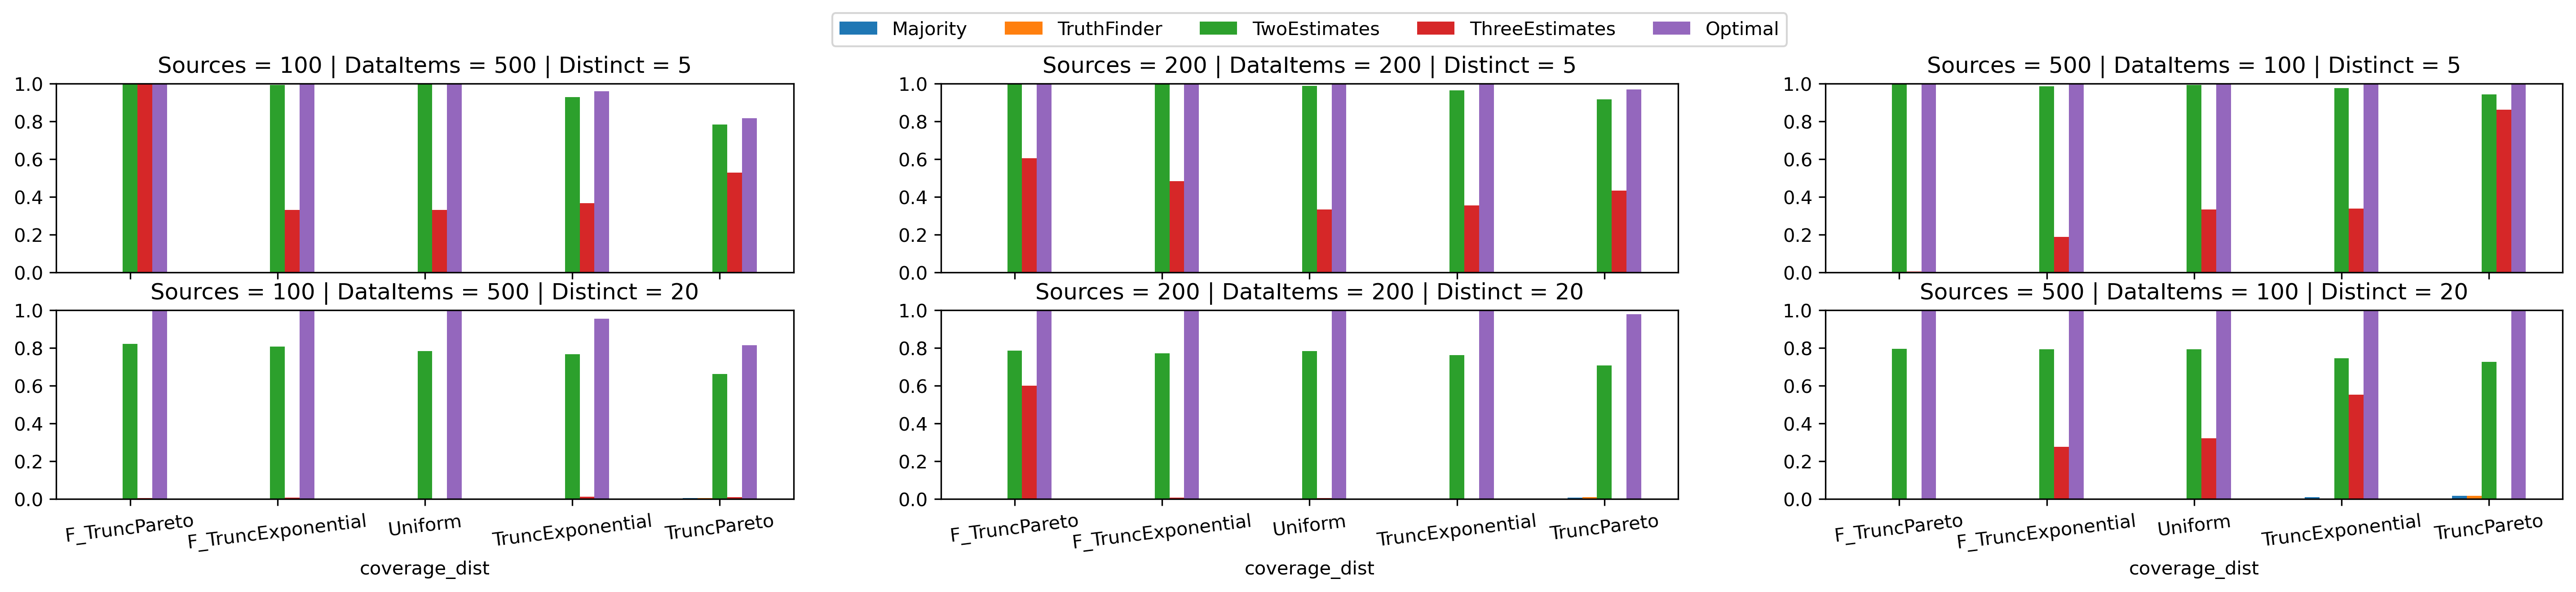

In [20]:
plot_distribution('F_TruncPareto', distribution='coverage_dist', percent=True)
plot_distribution('F_TruncExponential', distribution='coverage_dist', percent=True)
plot_distribution('Uniform', distribution='coverage_dist', percent=True)
plot_distribution('TruncExponential', distribution='coverage_dist', percent=True)
plot_distribution('TruncPareto', distribution='coverage_dist', percent=True)

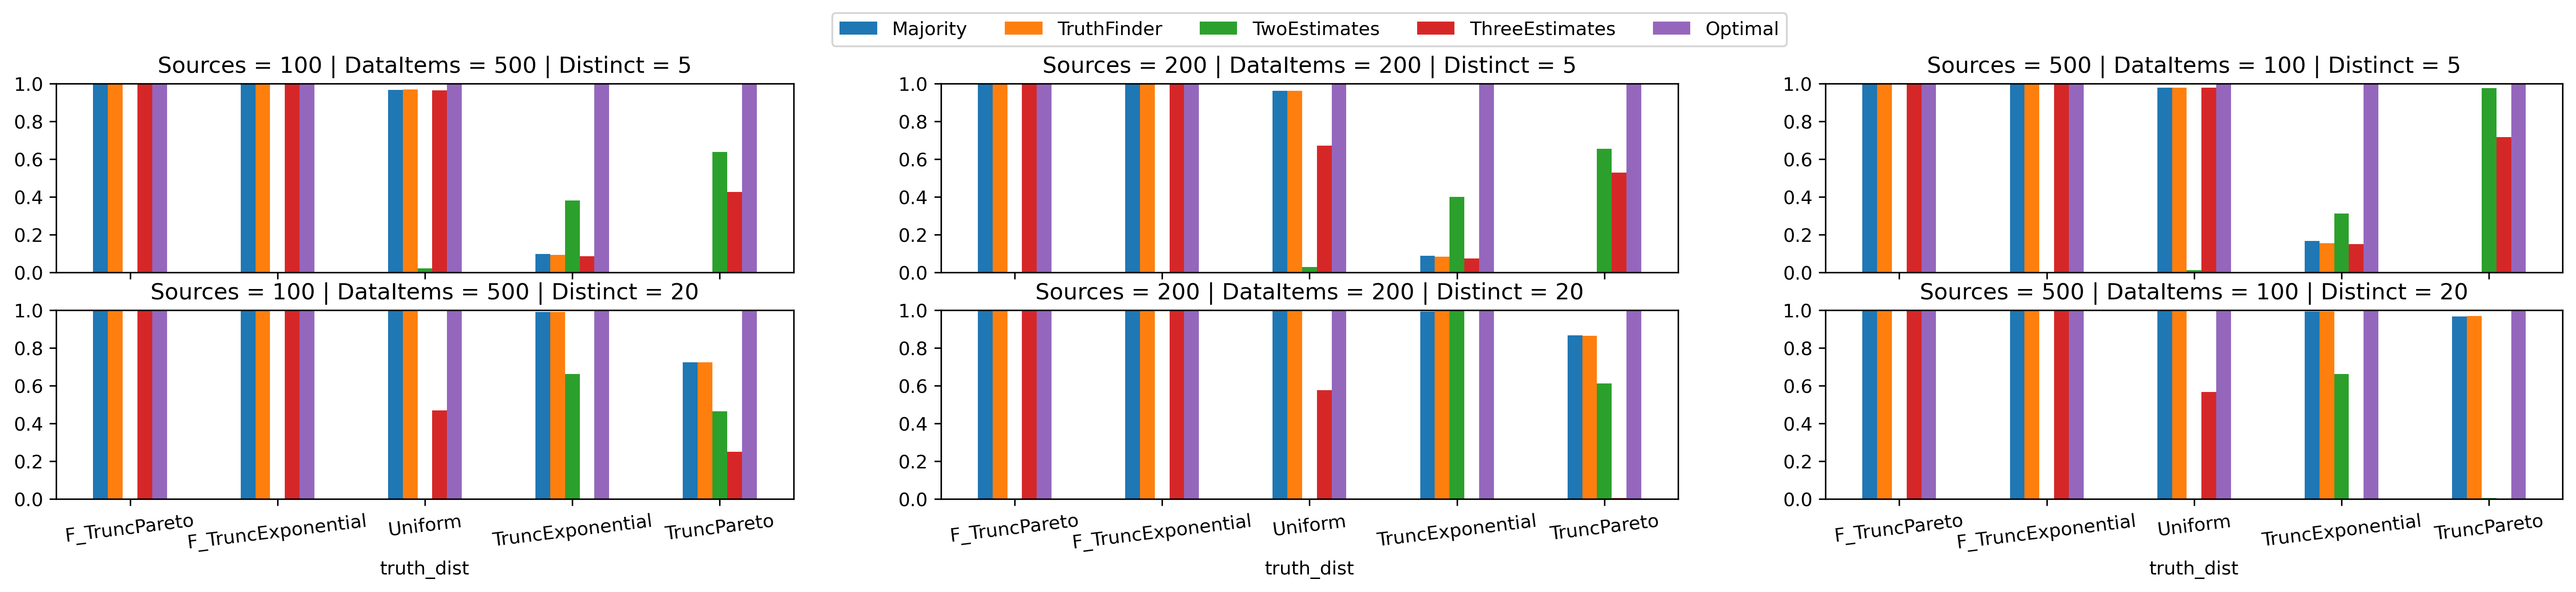

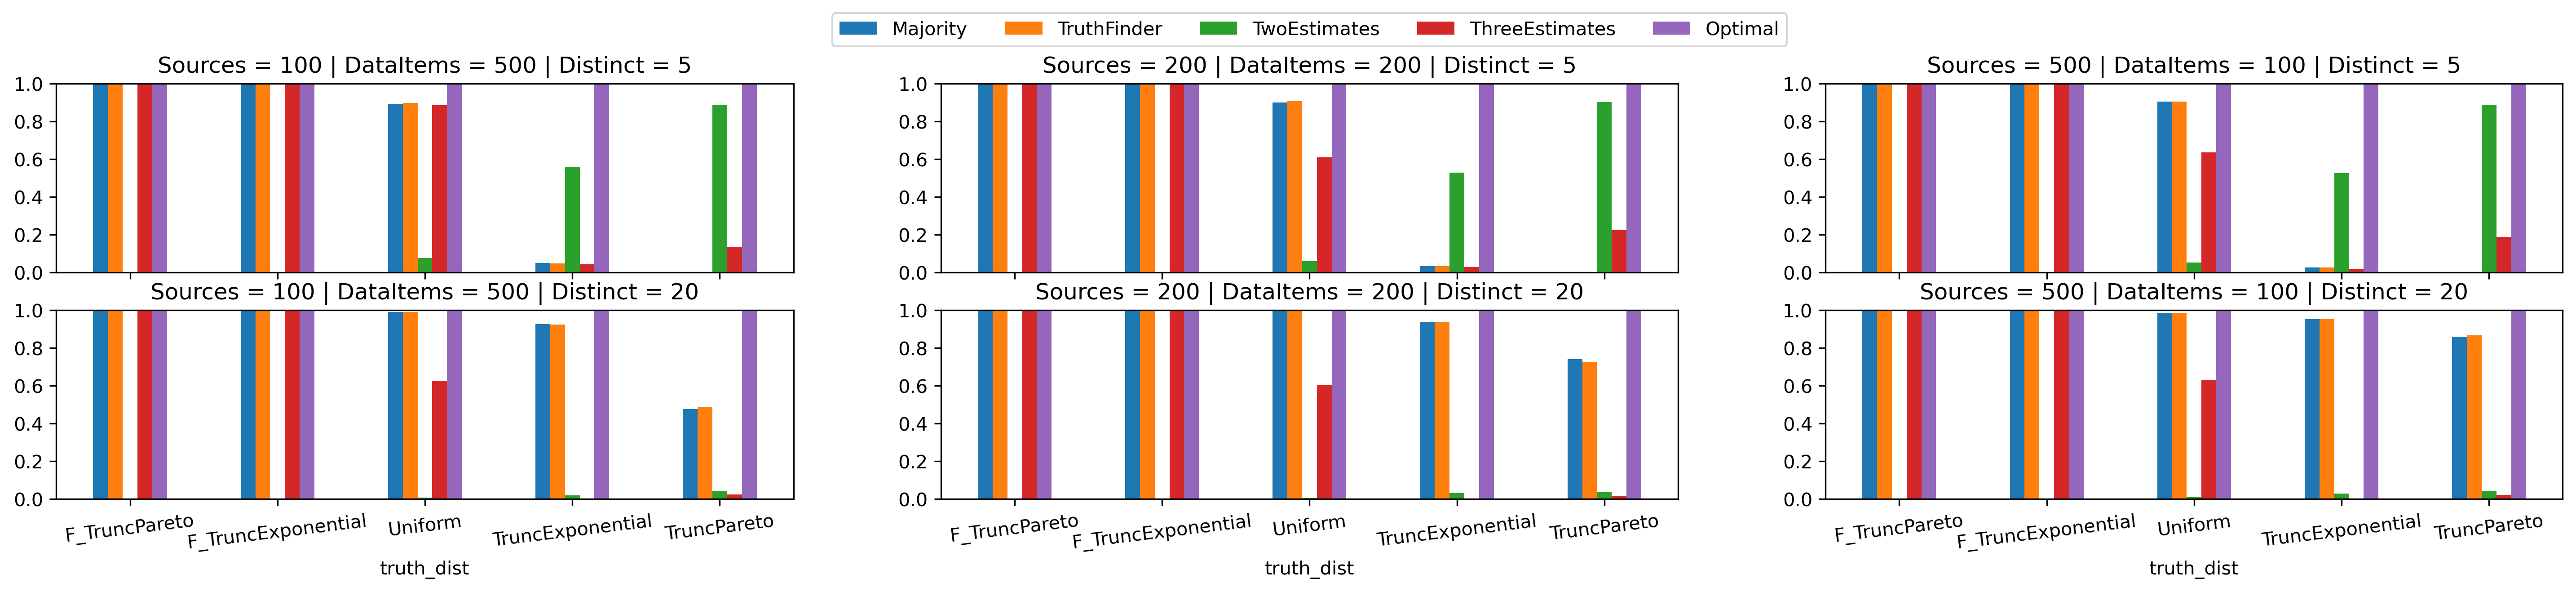

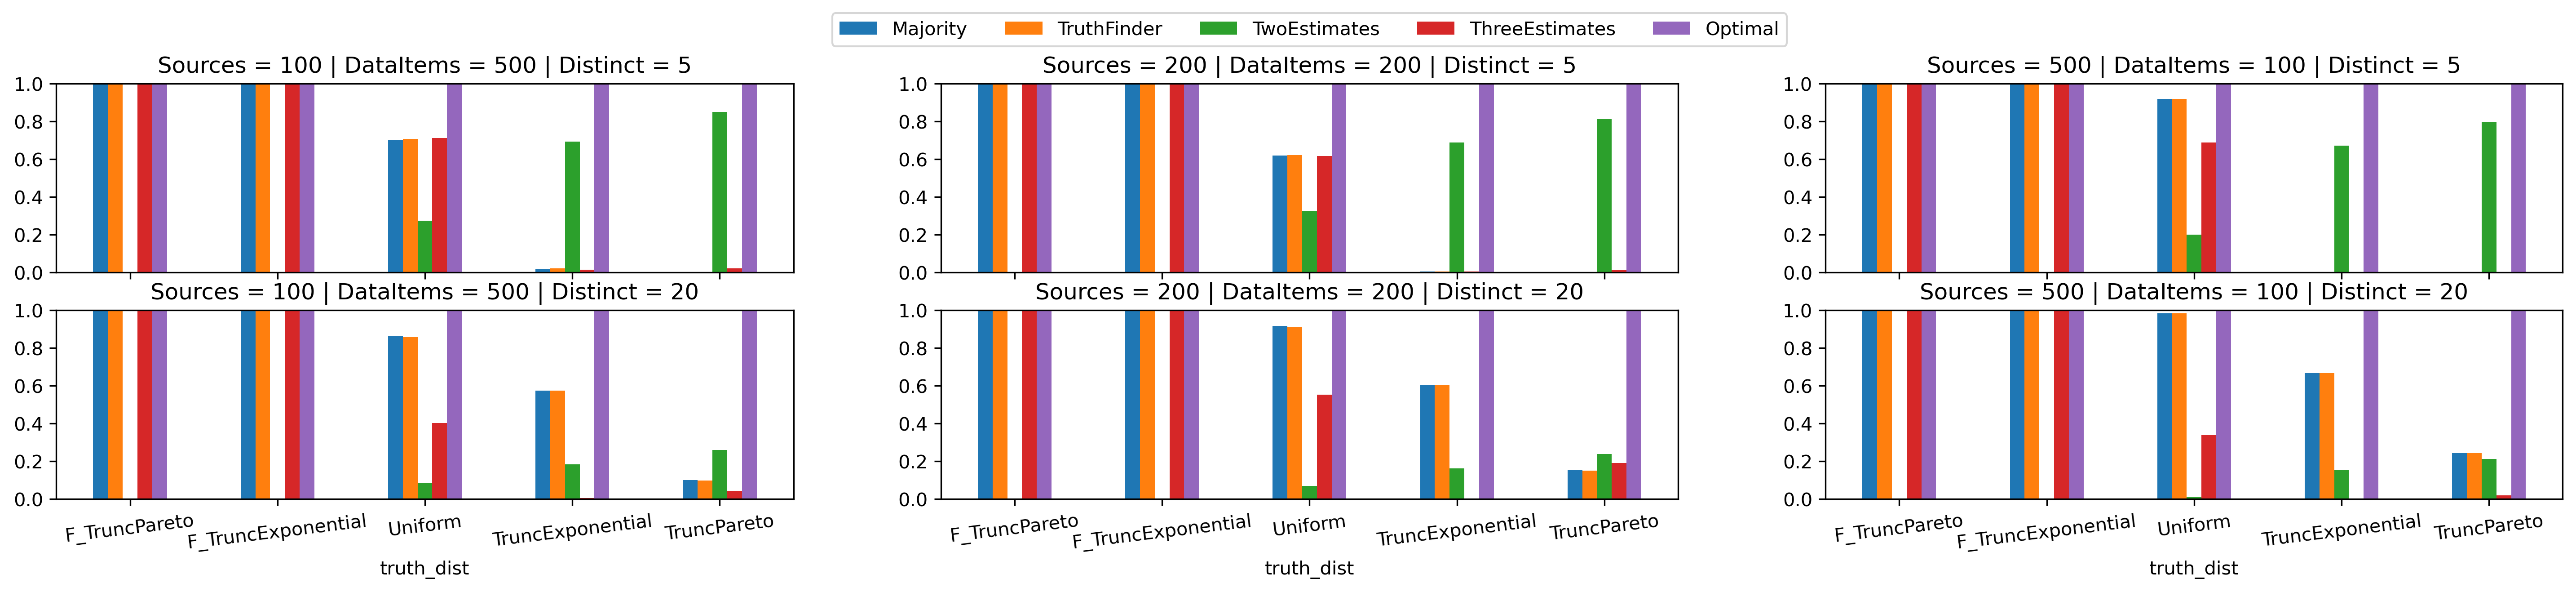

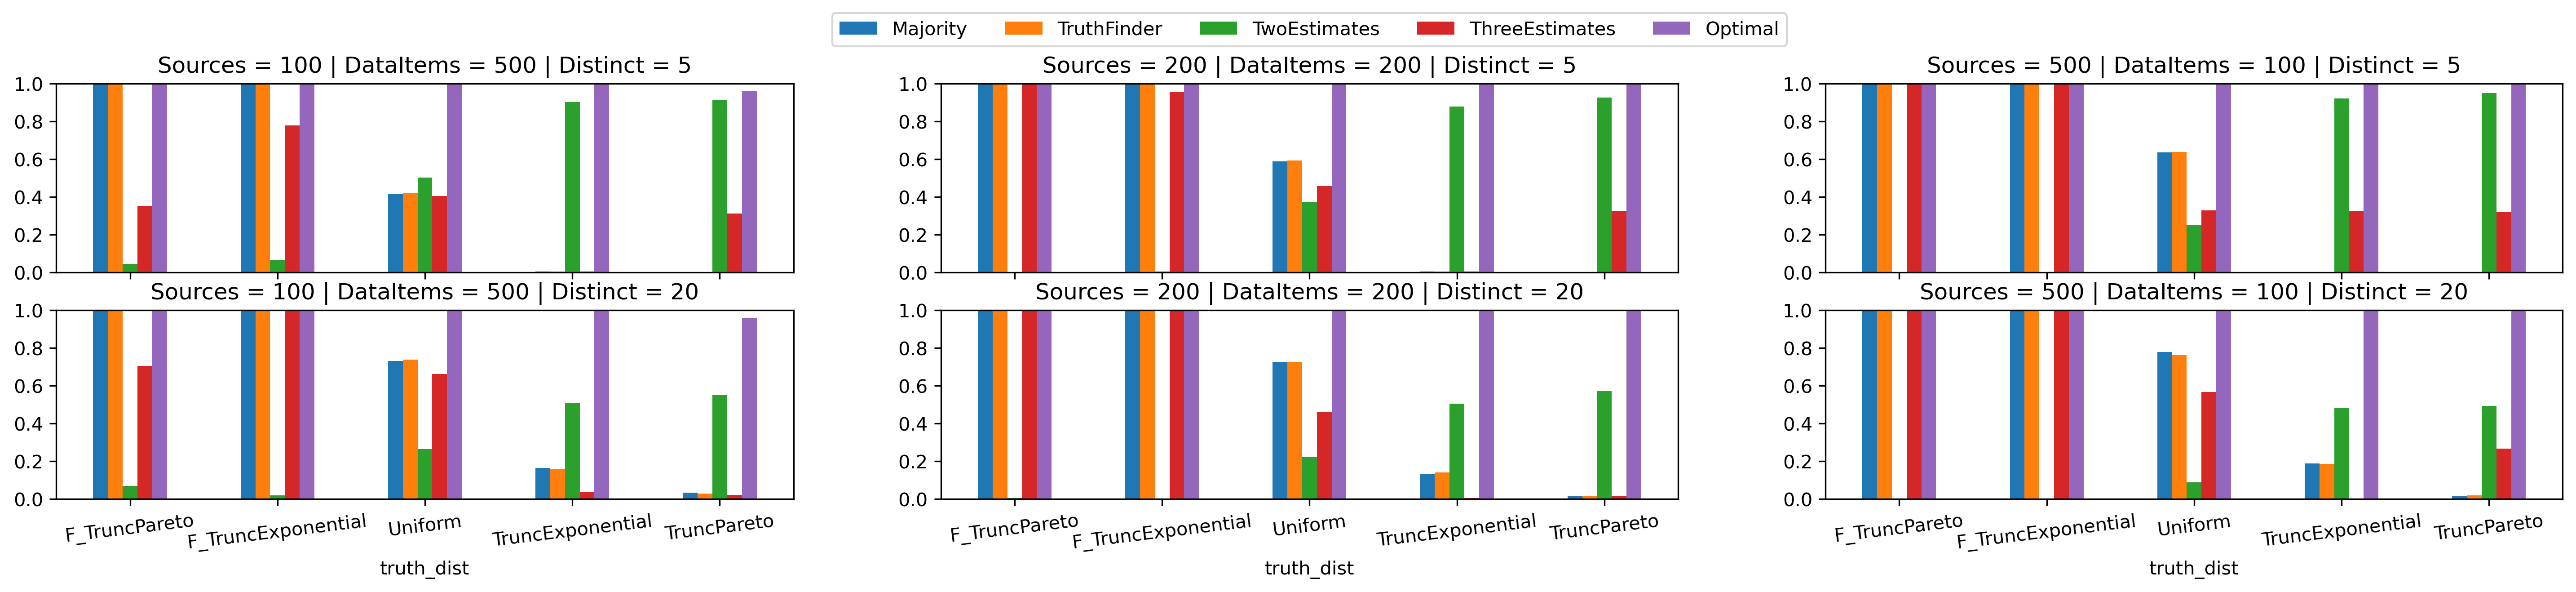

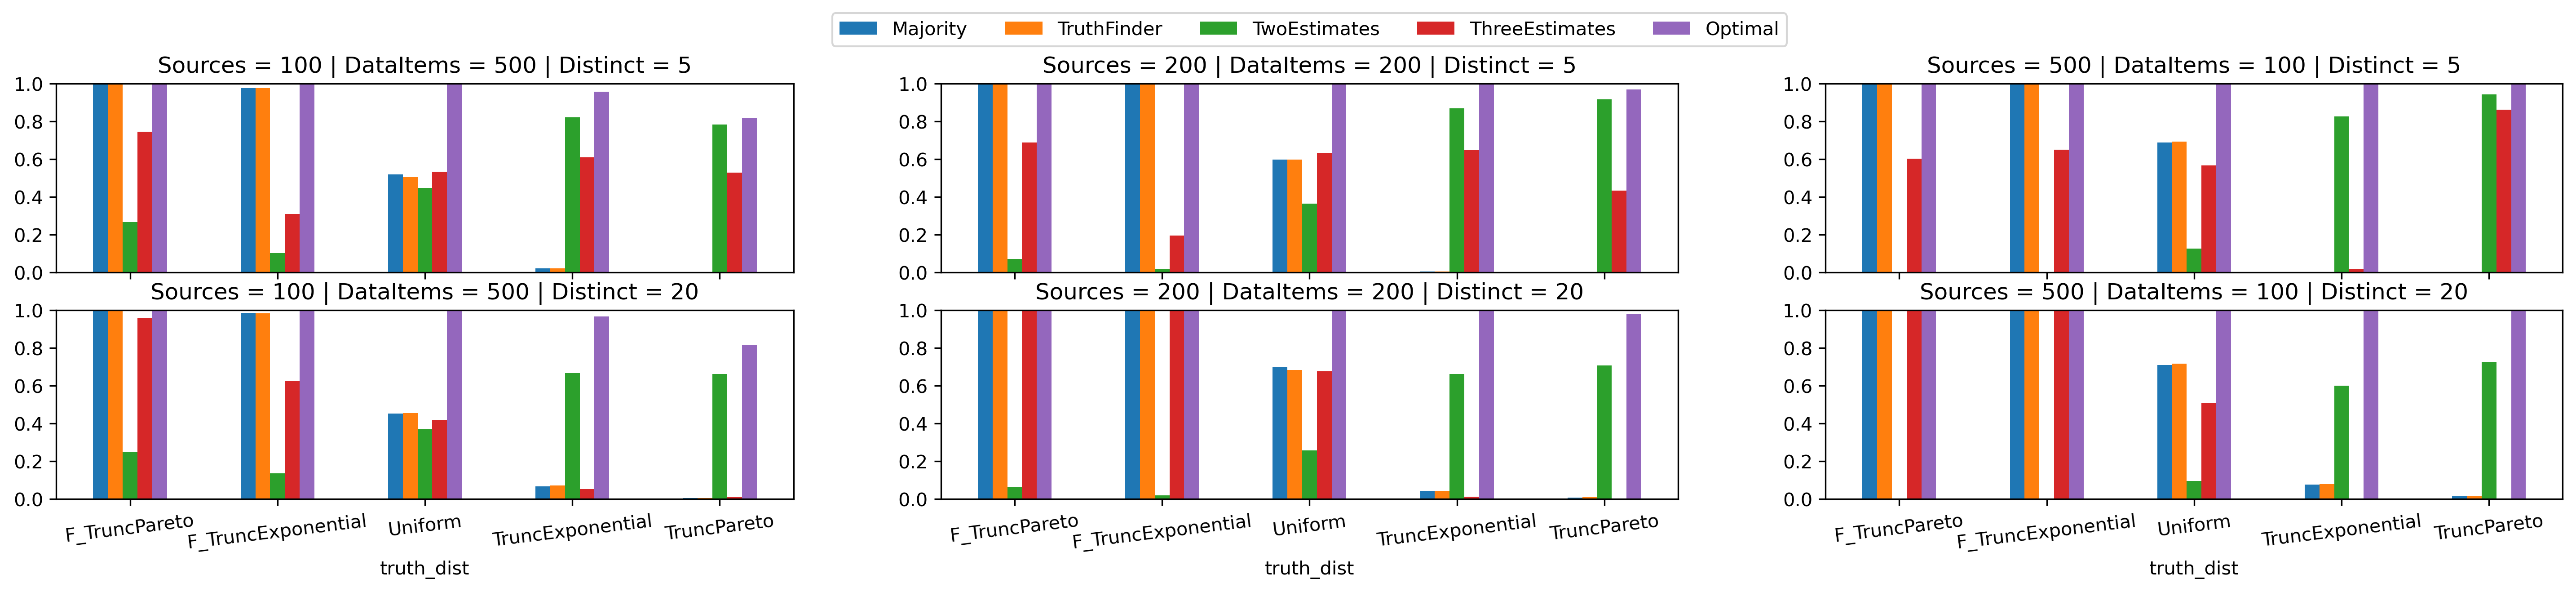

In [21]:
plot_distribution('F_TruncPareto', distribution='truth_dist', percent=True)
plot_distribution('F_TruncExponential', distribution='truth_dist', percent=True)
plot_distribution('Uniform', distribution='truth_dist', percent=True)
plot_distribution('TruncExponential', distribution='truth_dist', percent=True)
plot_distribution('TruncPareto', distribution='truth_dist', percent=True)

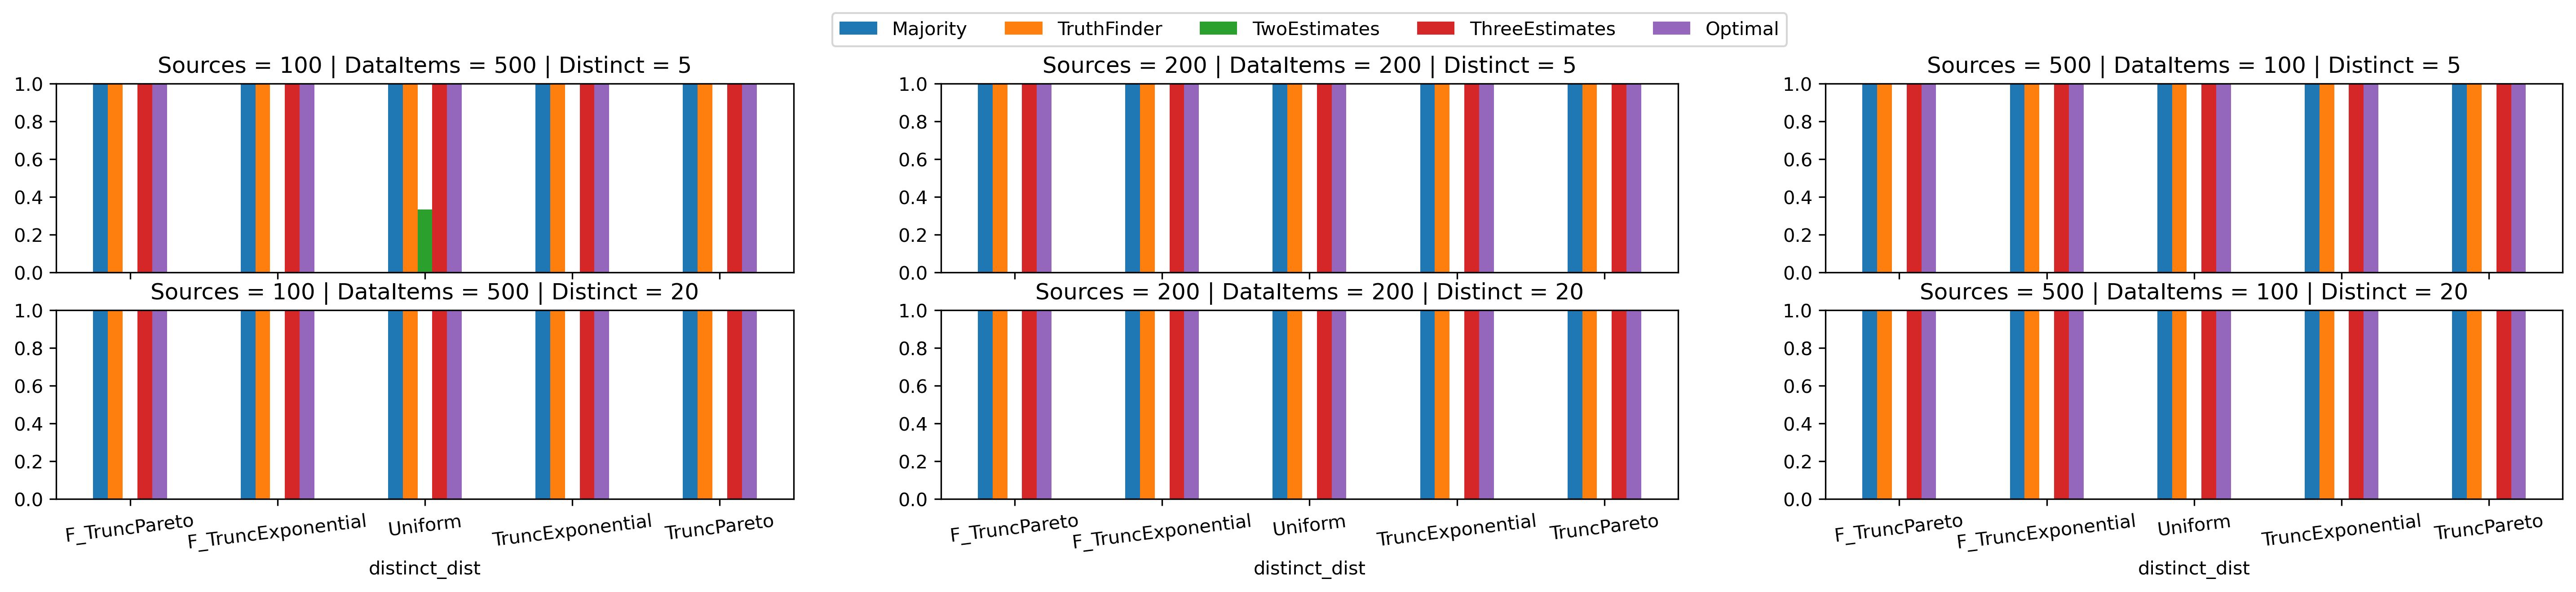

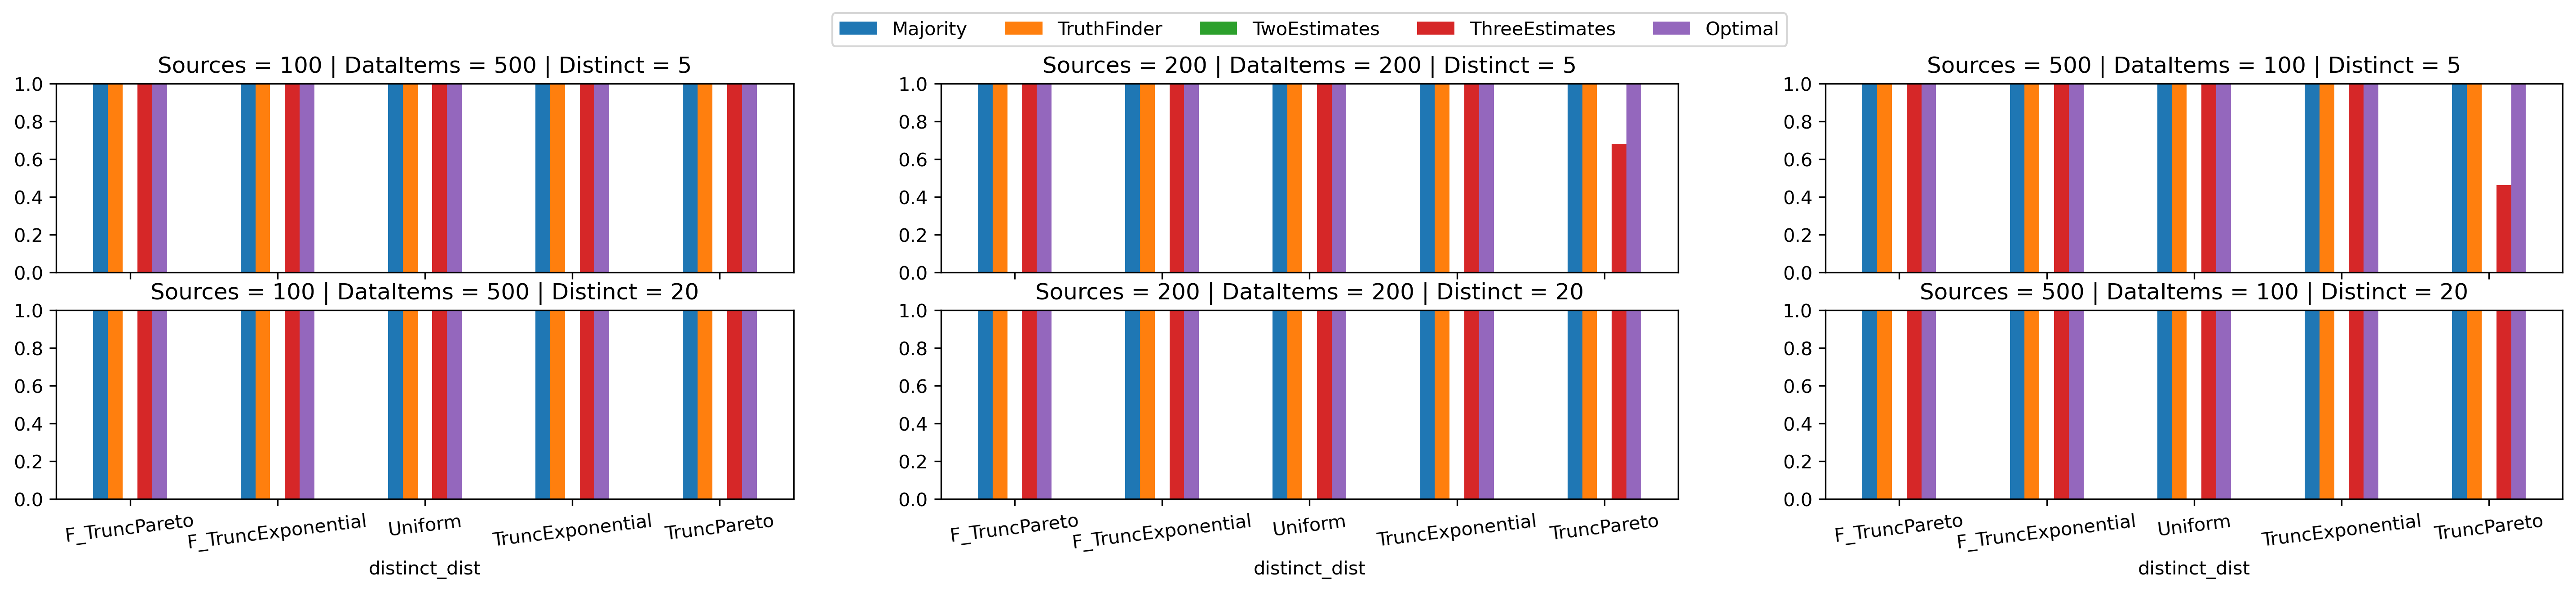

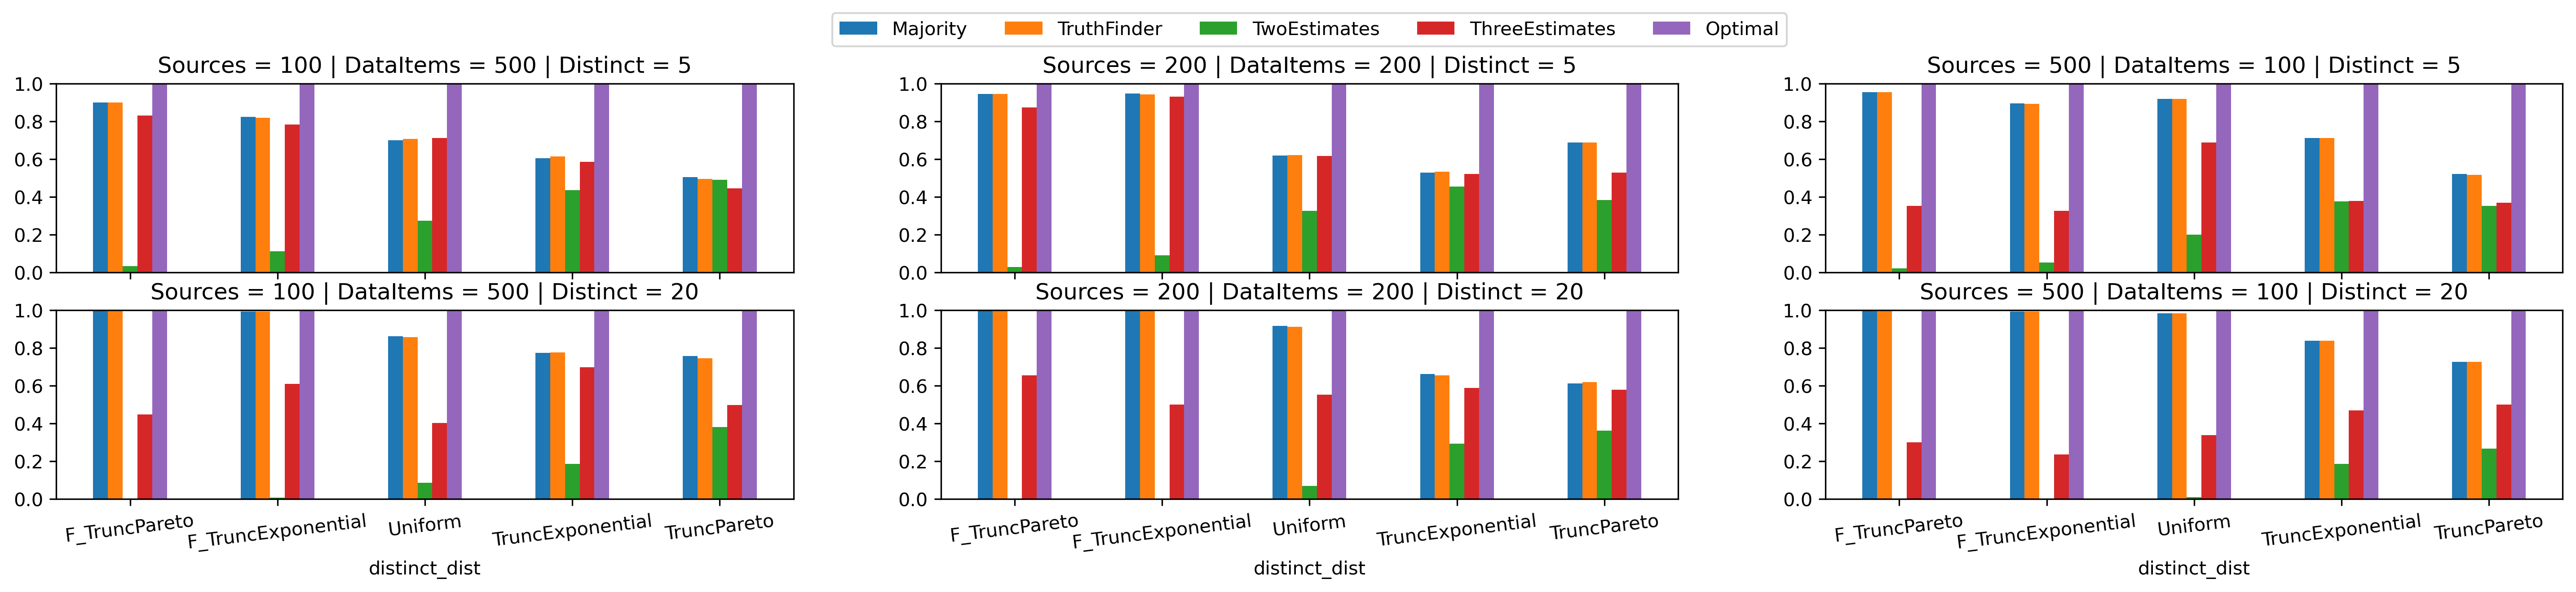

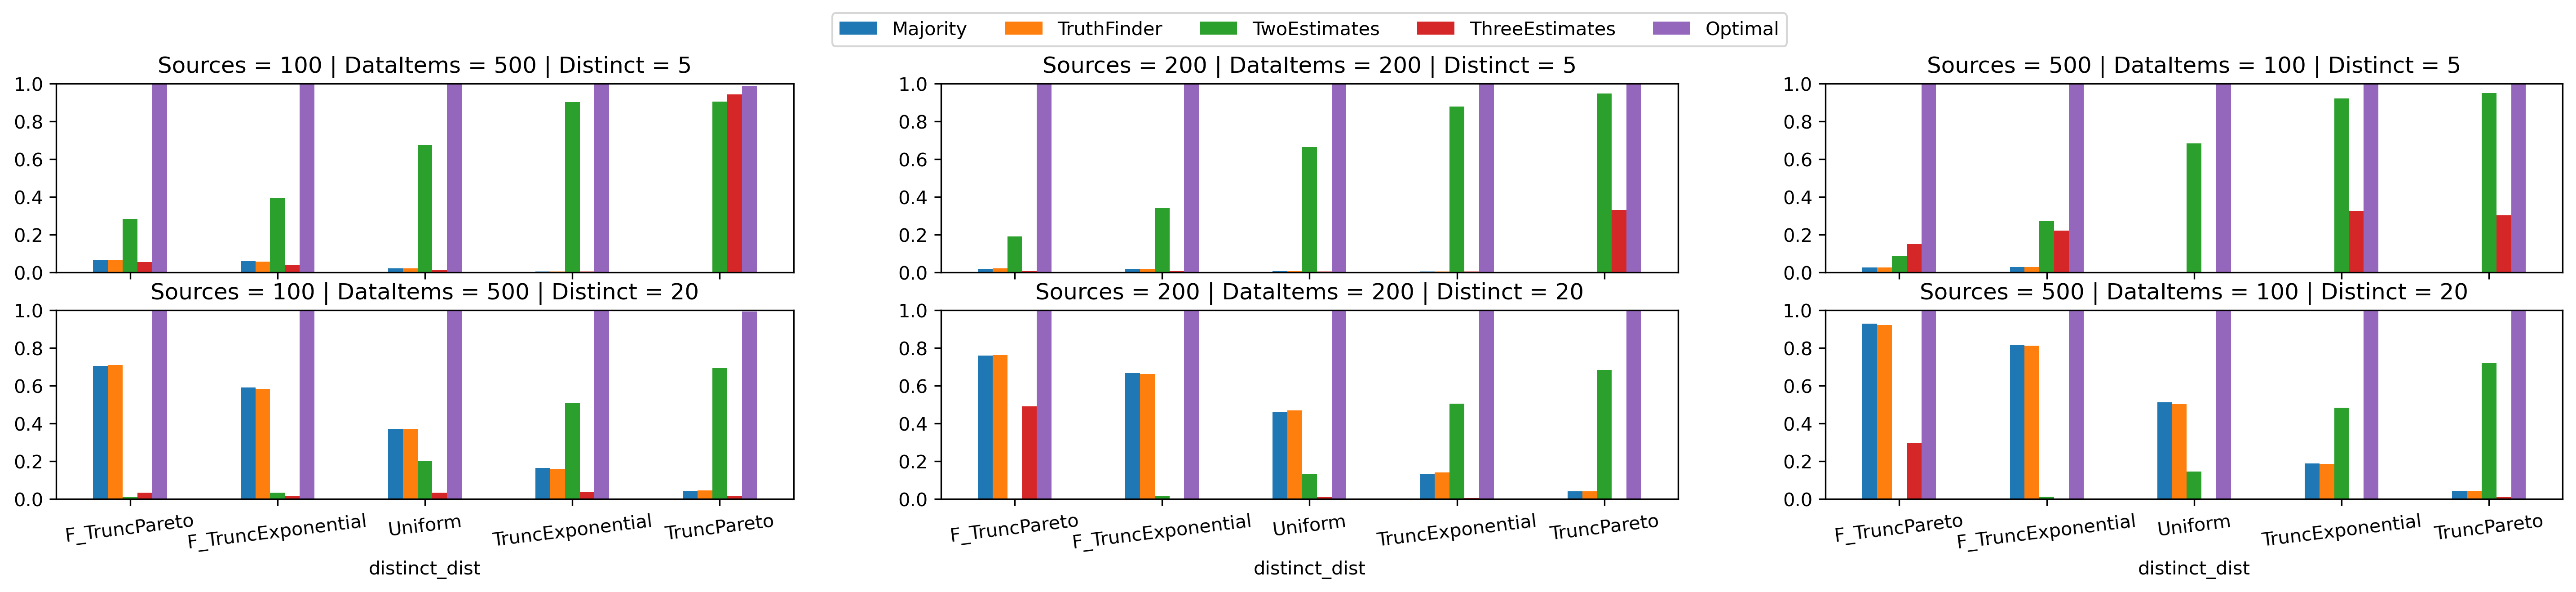

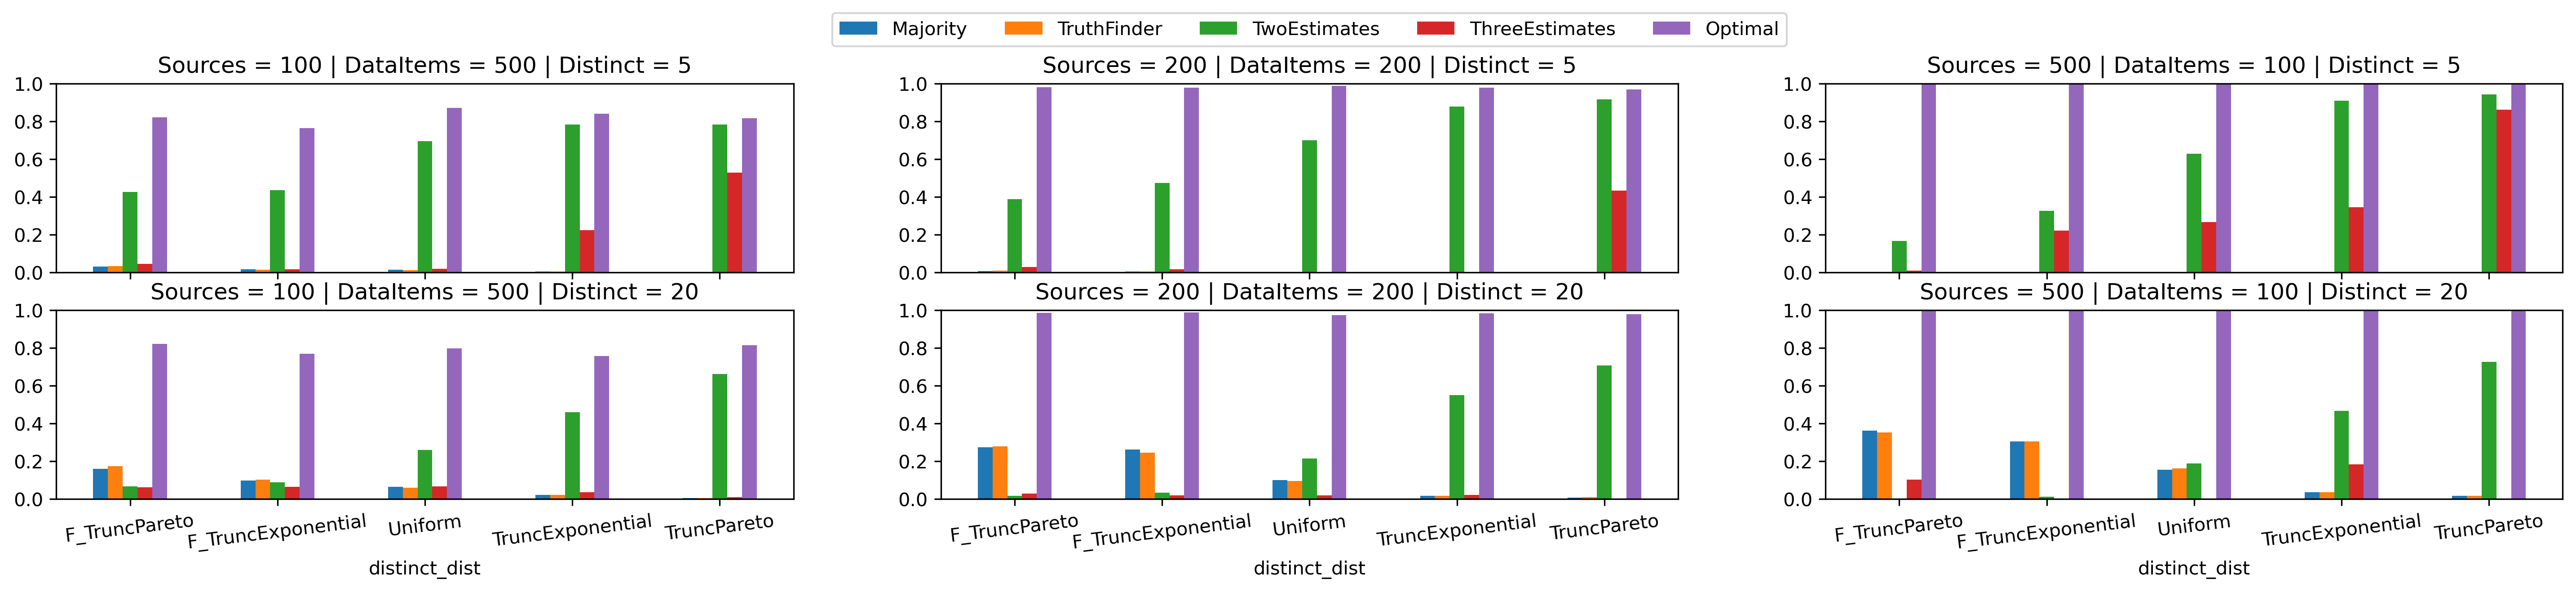

In [22]:
plot_distribution('F_TruncPareto', distribution='distinct_dist', percent=True)
plot_distribution('F_TruncExponential', distribution='distinct_dist', percent=True)
plot_distribution('Uniform', distribution='distinct_dist', percent=True)
plot_distribution('TruncExponential', distribution='distinct_dist', percent=True)
plot_distribution('TruncPareto', distribution='distinct_dist', percent=True)

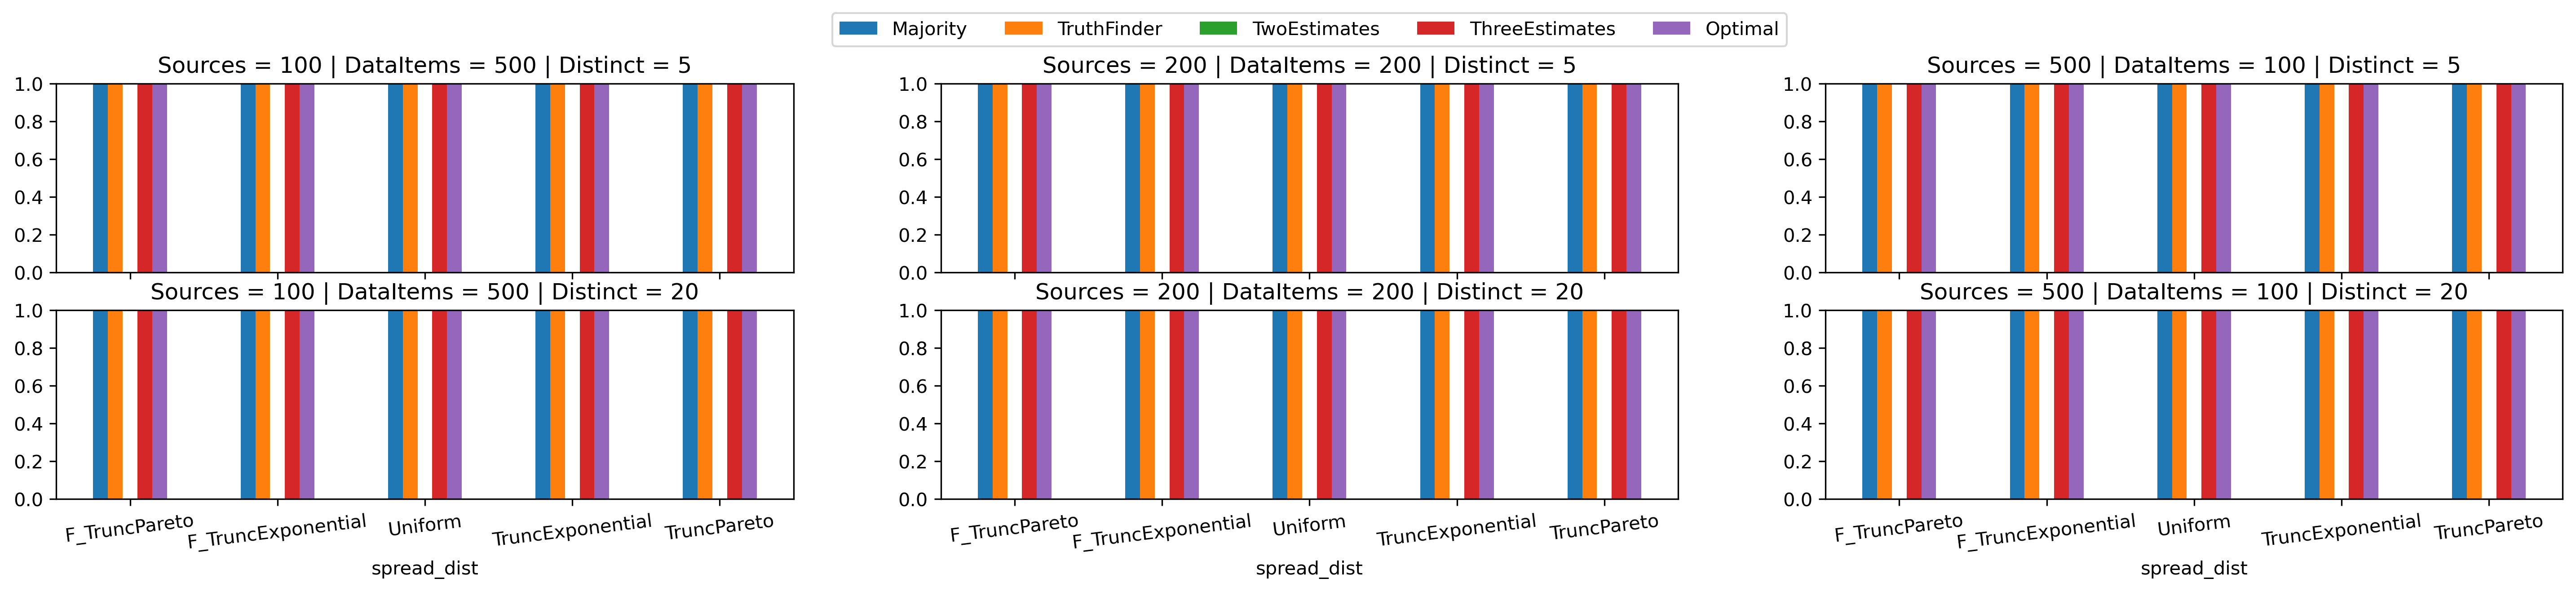

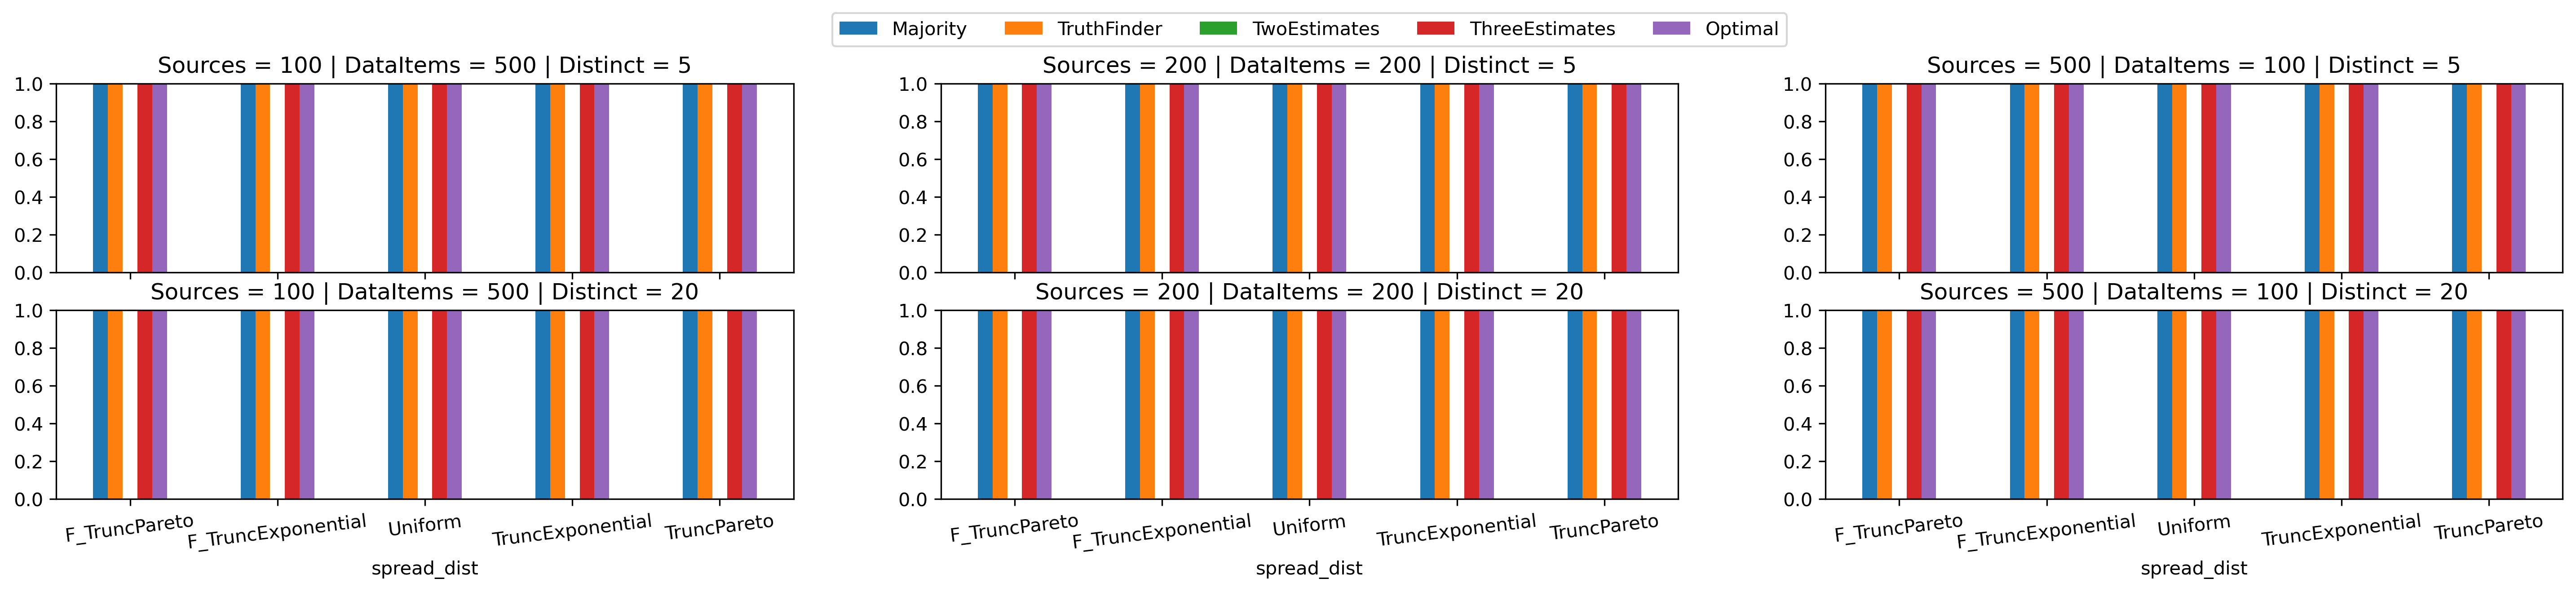

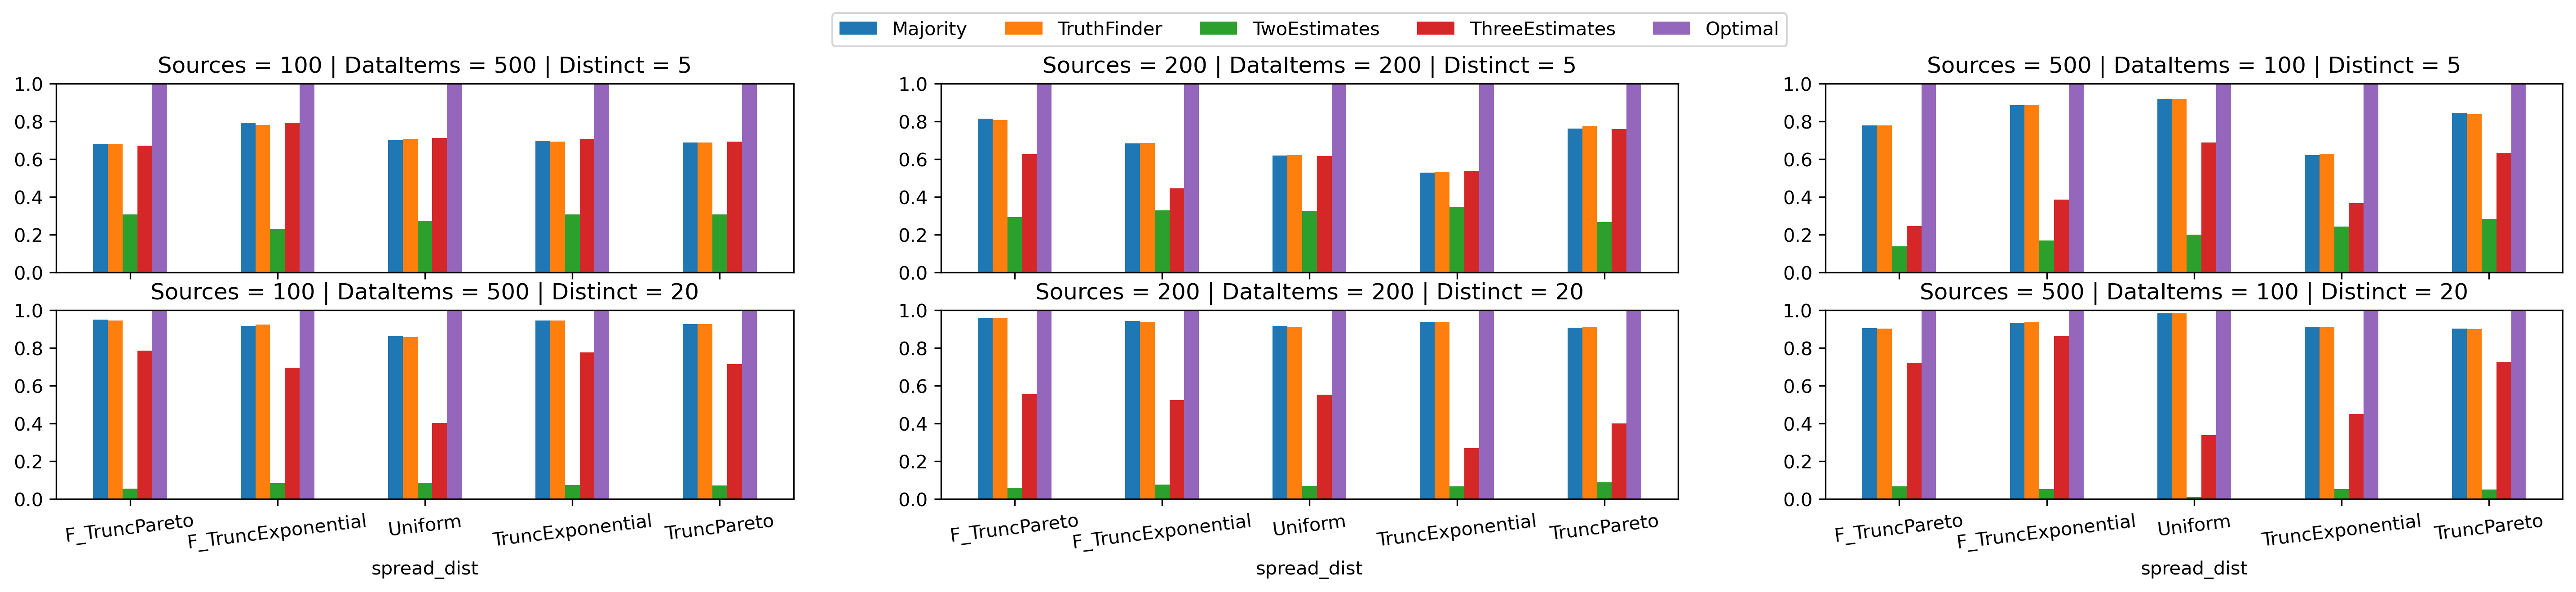

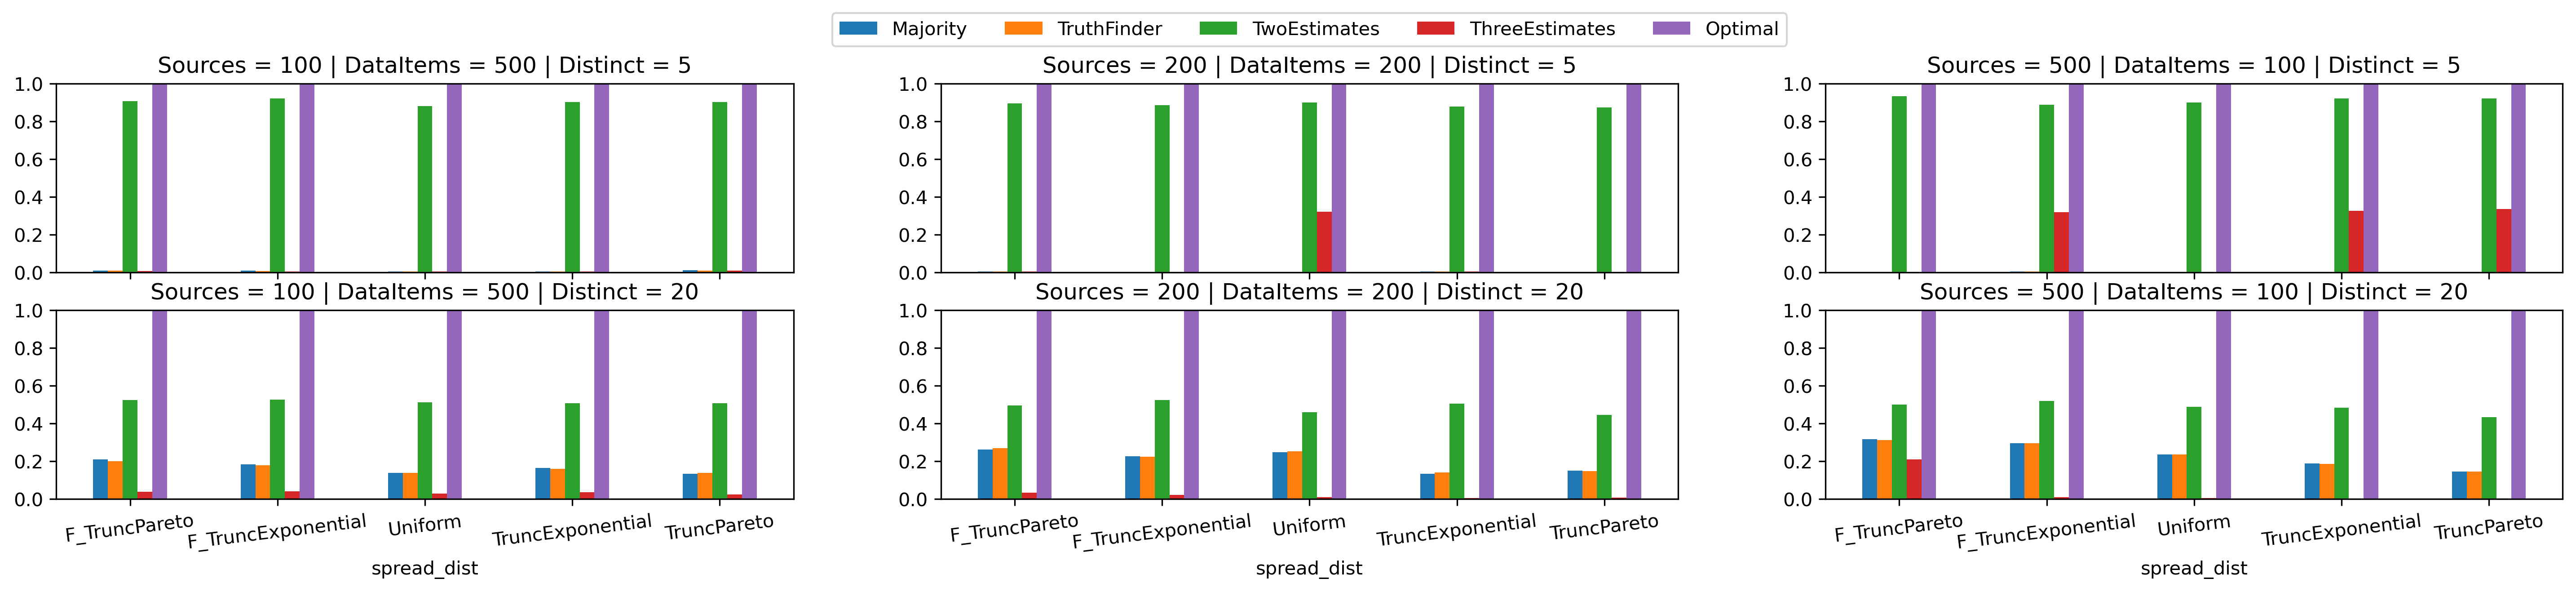

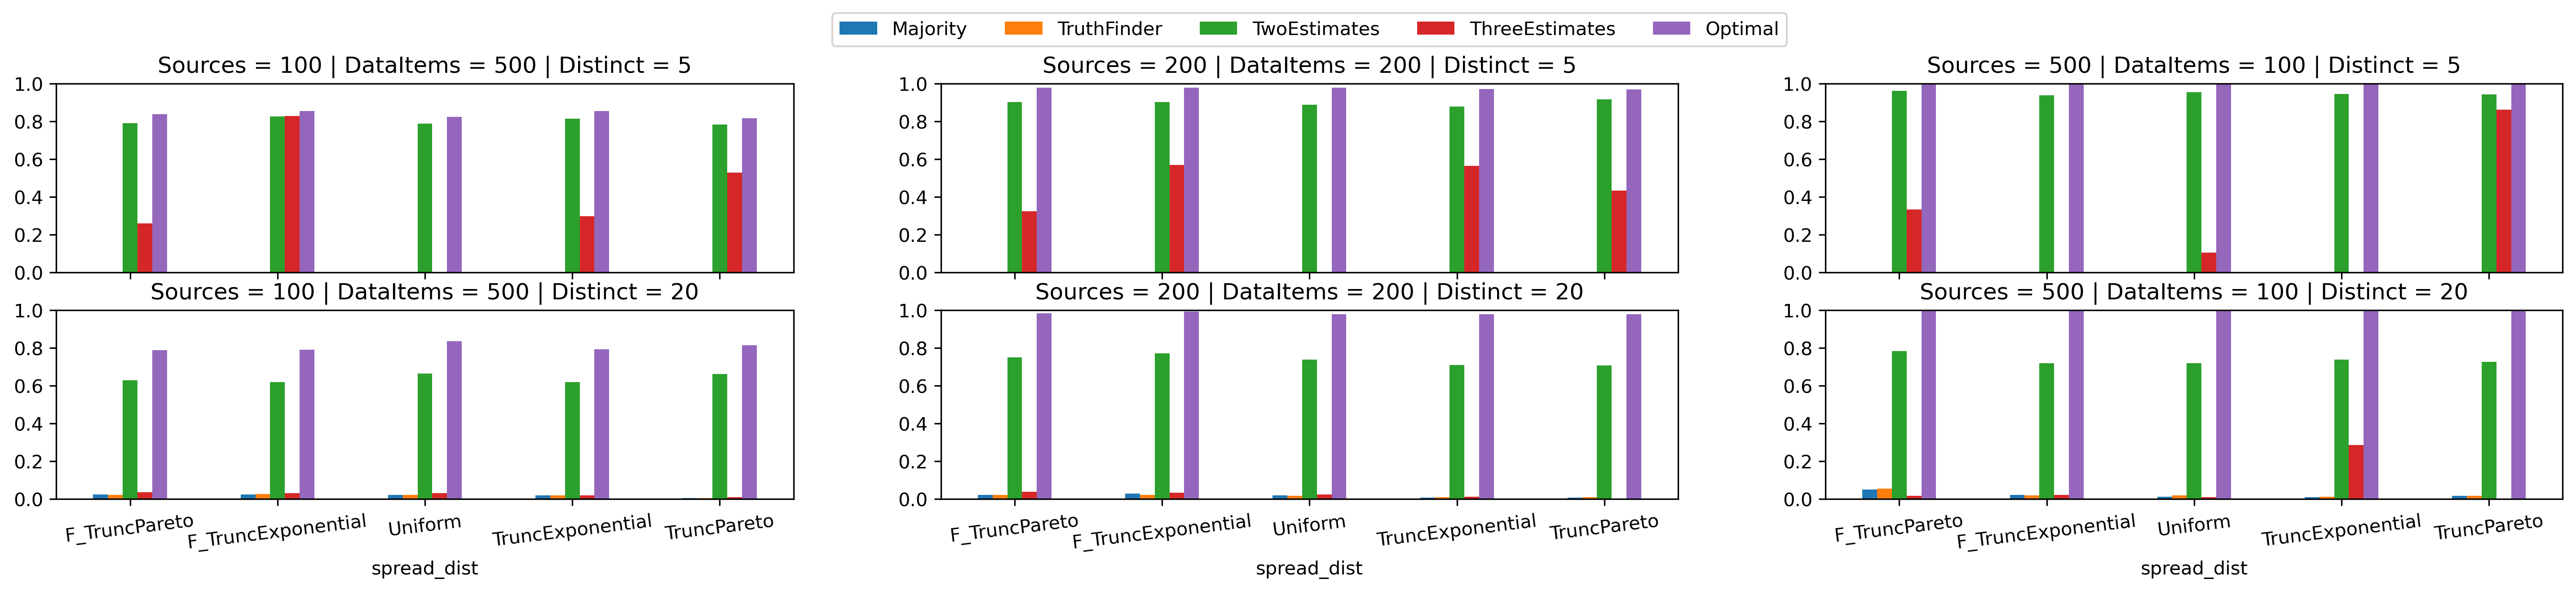

In [23]:
plot_distribution('F_TruncPareto', distribution='spread_dist', percent=True)
plot_distribution('F_TruncExponential', distribution='spread_dist', percent=True)
plot_distribution('Uniform', distribution='spread_dist', percent=True)
plot_distribution('TruncExponential', distribution='spread_dist', percent=True)
plot_distribution('TruncPareto', distribution='spread_dist', percent=True)